

---
**What are we trying to analyze?**

1. We want to see how the LSTM learns short and long term
2. We want to see how it learns if noise is low or high
3. We want to see if different cells pick up different characteristics

# Neural Network Analysis

## Table of Contents

1. [Start ML Process](#start-ml-process)
    - [Create Train-Test-Split w/ Shuffled Sample](#create-train-test-split-w-shuffled-sample)
    - [LSTM Architecture](#lstm-architecture)
        - [Real Set-Up](#real-set-up)
    - [1. Low Noise Data](#1-low-noise-data)
    - [2. High Noise Data](#2-high-noise-data)
    - [Get LSTM Cell weights](#get-lstm-cell-weights)
    - [Extract Meaning from Final Cell States](#extract-meaning-from-final-cell-states)
    - [Extract Meaning from the hidden cell activations](#extract-meaning-from-the-hidden-cell-activations)
2. [Saving and Loading Data](#saving-and-loading-data)

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, TimeDistributed, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Layer
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Get the current working directory (where your notebook is)
current_directory = os.getcwd()

# Construct the full path to your data_utils.py file
data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

# Now you can import the custom module
import data_utils as du
import analysis_utils as au

sys.path = []

In [ ]:
# ONLY FOR RELOAD!

# Reloads if the data_utils has been updated during runtime
# Always need to add and reset the paths
import importlib

data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

importlib.reload(du)  # This reloads the module
importlib.reload(au)  # This reloads the module

sys.path = []

### Data Loading and Preprocessing

In [4]:
# Loading the Model Configuations Dictionary

configs_base_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Model Configurations/"
config_file_binary_path = f"{configs_base_path}model_configs_binary_multi_noise.json"
config_file_multiple_path = f"{configs_base_path}model_configs_multiple.json"


In [5]:
model_configs_binary = du.load_data_configs_json(config_file_binary_path)
model_configs_multiple = du.load_data_configs_json(config_file_multiple_path)

In [8]:
data_configs = model_configs_multiple
data_configs.keys()

dict_keys(['all_features_multi', 'signal_multi', 'hilbert_only_multi', 'hilbert_included_multi', 'wavelet_only_multi', 'wavelet_inlcuded_multi'])

In [20]:
# DATA LOADING

# I decided to make all config files work with the same data and label vectors
# Previously when loading many different models or the same multiple time,
# the runtime would crash

data, label = du.load_data(data_configs["all_features_multi"]["data_path"], data_configs["all_features_multi"]["label_path"])

du.data_info(data)

DATASET INFO:
Shape: (10, 20, 5, 7500, 25)

No of Samples: 10

No of Frequencies: 20
Freqency values: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(13), np.int64(16), np.int64(18), np.int64(22), np.int64(26), np.int64(31), np.int64(36), np.int64(43), np.int64(51), np.int64(60), np.int64(71), np.int64(84), np.int64(100)]

No of noise ratios: 5
Signal to Noise ratios (in db) [np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8)]

No of Datapoints: 7500

No of Features per Datapoint: 25 (signal, hilbert amp, 20 wavelets for each freq)


In [21]:
# Trim Data to leave some validation analysis
# (Allowing to maintain noise and freq as paramters to be checked
data = data[:5]
label = label[:5]

In [22]:
label.shape

(5, 20, 5, 7500)

In [23]:
# This will take a while, as it is loading the data (aroung 1-2GB)

# Example usage:
# Process all configurations:
data_dict = du.create_data_dict(data_configs, universal_data=data, universal_label=label)

# Process a subset of configurations:
selected_configs = ['high_noise_beta_all_features_binary', 'high_noise_beta_amp_feature_binary', 'low_noise_beta_binary']

# This will reshape the data into another dict but already transformed for LSTMs
# data_dict = du.create_data_dict(data_configs, config_names=selected_configs)

au.explain_dict_structure(data_dict)

all_features_multi:
   Type: <class 'tuple'>
signal_multi:
   Type: <class 'tuple'>
hilbert_only_multi:
   Type: <class 'tuple'>
hilbert_included_multi:
   Type: <class 'tuple'>
wavelet_only_multi:
   Type: <class 'tuple'>
wavelet_inlcuded_multi:
   Type: <class 'tuple'>



In [29]:
print(data_dict["wavelet_only_multi"][0].shape)
data_dict["all_features_multi"][1].shape

(500, 7500, 20)


(500, 7500, 1)

## Only Binary (extract Beta Oscillation Features)

In [ ]:
data_dict.keys()

dict_keys(['beta_binary_signal_deep'])

In [ ]:
beta_hilbert_incl_index = [0,3]
beta_hilbert_only_index = [3]
beta_wavelet_incl_index = [0,12,13,14,15,16]
beta_wavelet_only_index = [12,13,14,15,16]
beta_allF_index         = beta_hilbert_incl_index + beta_wavelet_only_index

# Convert the tuple to a list, modify the list, then convert it back to a tuple
temp_list = list(data_dict['beta_binary_hilbert_included'])
temp_list[0] = temp_list[0][:, :, beta_hilbert_incl_index]
data_dict['beta_binary_hilbert_included'] = tuple(temp_list)

# Do the same for the other keys
temp_list = list(data_dict['beta_binary_hilbert_only'])
temp_list[0] = temp_list[0][:, :, beta_hilbert_only_index]
data_dict['beta_binary_hilbert_only'] = tuple(temp_list)

temp_list = list(data_dict['beta_binary_wavelet_included'])
temp_list[0] = temp_list[0][:, :, beta_wavelet_incl_index]
data_dict['beta_binary_wavelet_included'] = tuple(temp_list)

temp_list = list(data_dict['beta_binary_wavelet_only'])
temp_list[0] = temp_list[0][:, :, beta_wavelet_only_index]
data_dict['beta_binary_wavelet_only'] = tuple(temp_list)

temp_list = list(data_dict['beta_binary_all_features'])
temp_list[0] = temp_list[0][:, :, beta_allF_index]
data_dict['beta_binary_all_features'] = tuple(temp_list)

print(data_dict['beta_binary_hilbert_included'][0].shape)
print(data_dict['beta_binary_hilbert_only'][0].shape)
print(data_dict['beta_binary_wavelet_included'][0].shape)
print(data_dict['beta_binary_wavelet_only'][0].shape)
print(data_dict['beta_binary_all_features'][0].shape)

KeyError: 'beta_binary_hilbert_included'

## Only Multi (fix Wavelet Incl. Model)

In [30]:
data_dict.keys()

dict_keys(['all_features_multi', 'signal_multi', 'hilbert_only_multi', 'hilbert_included_multi', 'wavelet_only_multi', 'wavelet_inlcuded_multi'])

In [31]:
wavelet_remove_index = [1,2,3,4]



# Convert the tuple to a list, modify the list, then convert it back to a tuple
temp_list = list(data_dict['wavelet_inlcuded_multi'])
all_indices = np.arange(temp_list[0].shape[-1])
indices_to_keep = np.delete(all_indices, wavelet_remove_index)
print(indices_to_keep)

temp_list[0] = temp_list[0][:, :, indices_to_keep]
data_dict['wavelet_inlcuded_multi'] = tuple(temp_list)

[ 0  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [32]:
for key in data_dict.keys():
  print(key, data_dict[key][0].shape)

all_features_multi (500, 7500, 25)
signal_multi (500, 7500, 1)
hilbert_only_multi (500, 7500, 4)
hilbert_included_multi (500, 7500, 5)
wavelet_only_multi (500, 7500, 20)
wavelet_inlcuded_multi (500, 7500, 21)


# ML Process

## Create Train-Test-Split w/ Shuffled Sample

Currently an absolute mess!
Both Train and Testing must include all oscillation types, but since we have only 2 alpha sets per 20 set sample, it can be difficult.

Currently running on a 75/25 train-test split

Also class weights are awful.

We easily converge to just saying no burst detection and get 85% accuracy.
This sucks.

In [33]:
# Create the train-test splits
splits_dict = du.create_train_test_splits(data_dict)

X_train shape: (375, 7500, 25), y_train shape: (375, 7500, 1)
X_test shape: (125, 7500, 25), y_test shape: (125, 7500, 1)
X_train shape: (375, 7500, 1), y_train shape: (375, 7500, 1)
X_test shape: (125, 7500, 1), y_test shape: (125, 7500, 1)
X_train shape: (375, 7500, 4), y_train shape: (375, 7500, 1)
X_test shape: (125, 7500, 4), y_test shape: (125, 7500, 1)
X_train shape: (375, 7500, 5), y_train shape: (375, 7500, 1)
X_test shape: (125, 7500, 5), y_test shape: (125, 7500, 1)
X_train shape: (375, 7500, 20), y_train shape: (375, 7500, 1)
X_test shape: (125, 7500, 20), y_test shape: (125, 7500, 1)
X_train shape: (375, 7500, 21), y_train shape: (375, 7500, 1)
X_test shape: (125, 7500, 21), y_test shape: (125, 7500, 1)


In [35]:
# Saves the Train/Test Splits
du.save_splits_dict(splits_dict, '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/new_multi_splits_dict.pkl')

Splits dictionary saved to: /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/new_multi_splits_dict.pkl


In [36]:
splits_dict.keys()


dict_keys(['all_features_multi', 'signal_multi', 'hilbert_only_multi', 'hilbert_included_multi', 'wavelet_only_multi', 'wavelet_inlcuded_multi'])

### Train/Test Data Visualization

(Can be skipped)

In [39]:
y_test_all = splits_dict['all_features_multi']['y_test']
X_test_all = splits_dict['all_features_multi']['X_test']

y_train_all = splits_dict['all_features_multi']['y_train']
X_train_all = splits_dict['all_features_multi']['X_train']


y_test_signal = splits_dict['beta_binary_signal_deep']['y_test']
X_test_signal = splits_dict['beta_binary_signal_deep']['X_test']


KeyError: 'beta_binary_signal_deep'

In [40]:
## Train Split class distribution
unique, counts = np.unique(y_train_all, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Theta Percentage: {(counts[1]/(sum(counts))):.4f}")
print(f"Alpha  Percentage: {(counts[2]/(sum(counts))):.4f}")
print(f"Beta Percentage: {(counts[3]/(sum(counts))):.4f}")
print(f"Gamma Percentage: {(counts[3]/(sum(counts))):.4f}")

Class distribution: {np.int64(0): np.int64(1503736), np.int64(1): np.int64(337731), np.int64(2): np.int64(328912), np.int64(3): np.int64(307029), np.int64(4): np.int64(335092)}
Noise  Percentage: 0.5347
Theta Percentage: 0.1201
Alpha  Percentage: 0.1169
Beta Percentage: 0.1092
Gamma Percentage: 0.1092


In [41]:
print(y_test_all.shape)
print(X_test_all.shape)

(125, 7500, 1)
(125, 7500, 25)


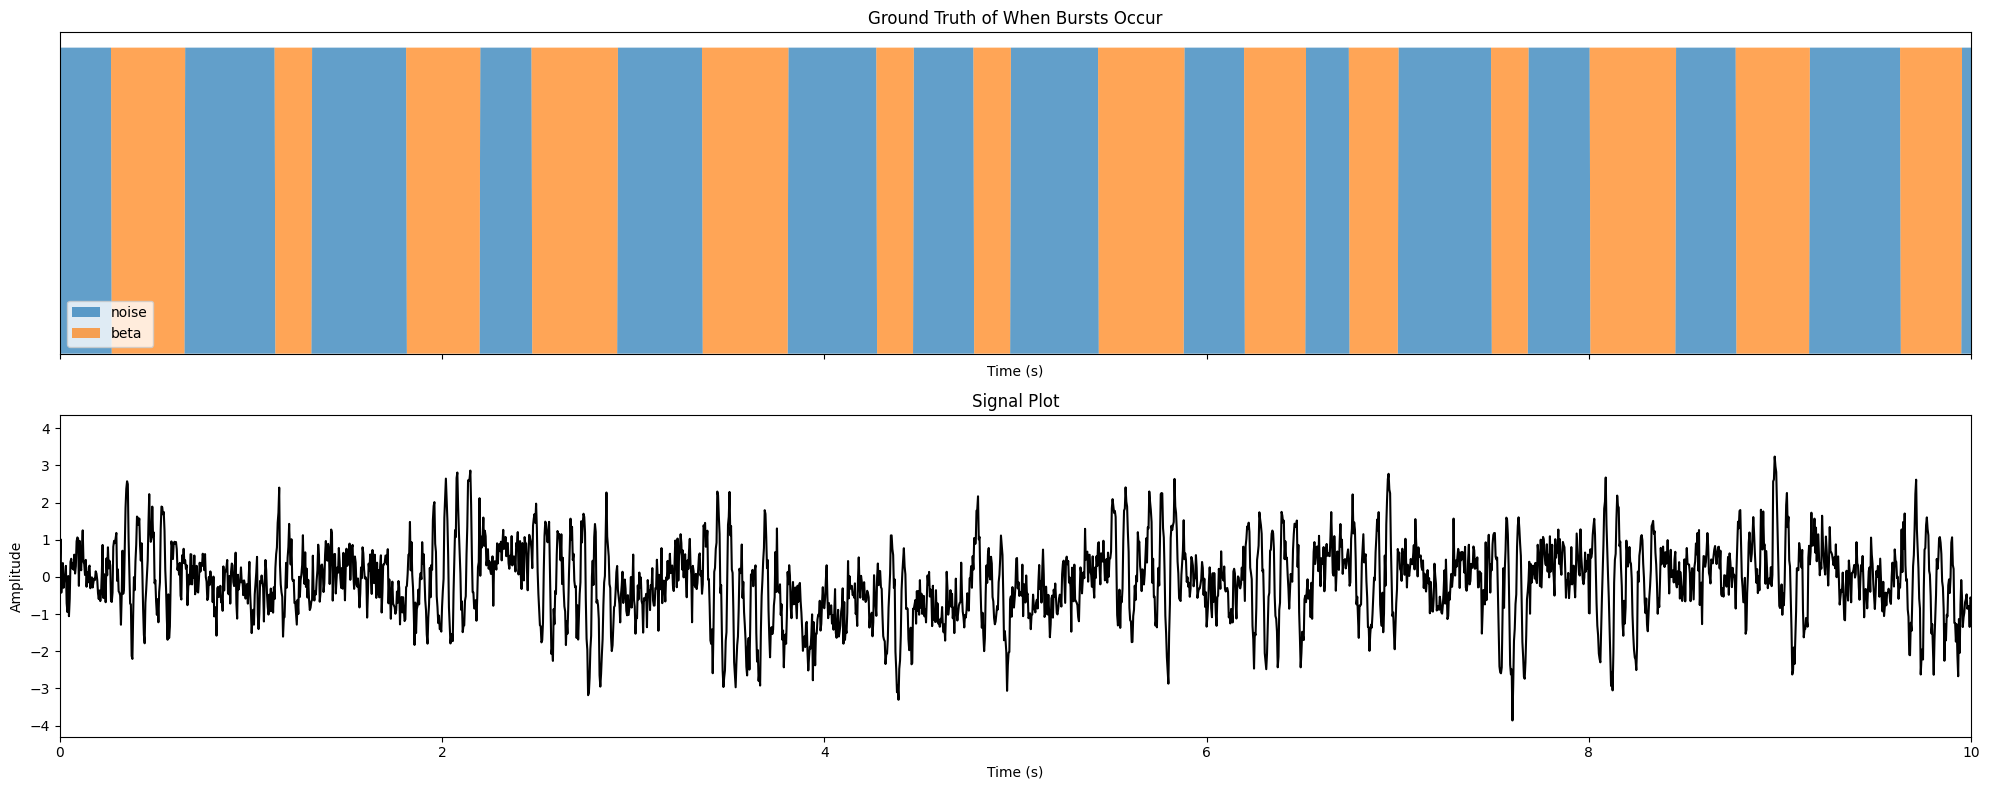

In [ ]:
# Use IF we DO NOT have FEATURES
sample_number = 3

label_sample_low = y_test_signal[sample_number].flatten()
signal_sample_low = X_test_signal[sample_number].flatten()

du.visualize_training_data(label_sample_low, signal_sample_low, duration=30)

(7500, 14)


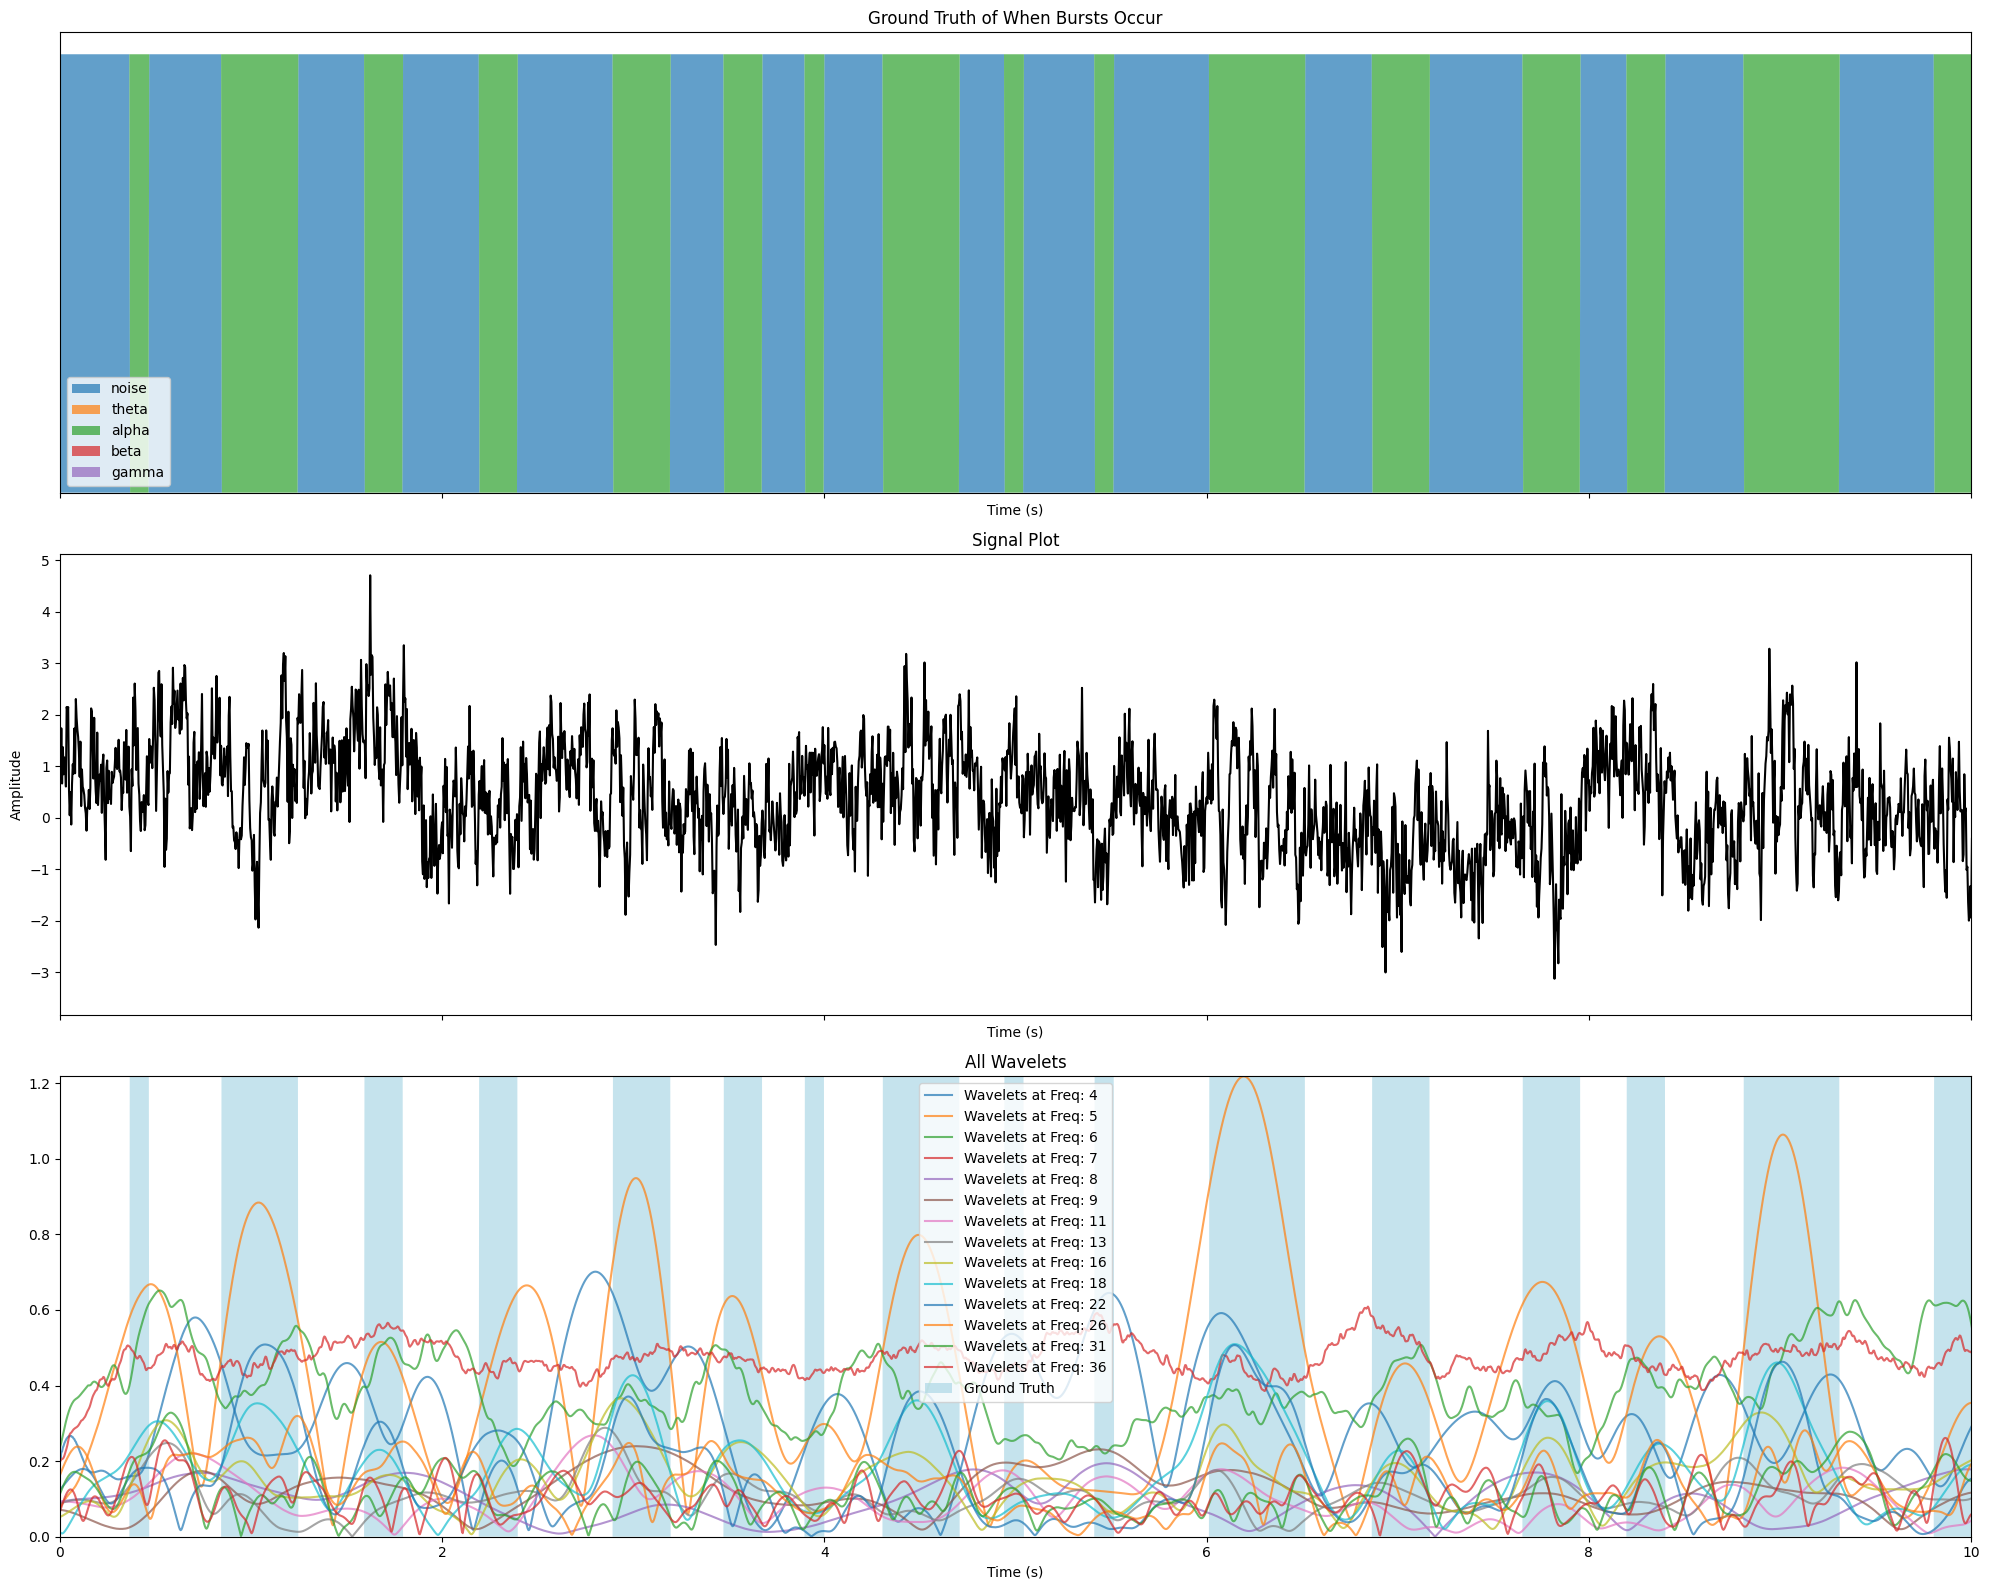

In [43]:
# Use IF we have FEATURES
 # (if seq_len !=15000 set the duration or freq attribute of the function accordingly)

sample_number = 4
label_sample_high = y_test_all[sample_number].flatten()
signal_sample_high = X_test_all[sample_number,:,0].flatten()
feature_sample_high = X_test_all[sample_number,:,1:15]

print(feature_sample_high.shape)

# Define category labels (adjust if you have different categories)
category_labels = ['noise', 'theta', 'alpha', 'beta', 'gamma']

# Call visualize_feature_data with the category_labels argument
du.visualize_feature_data(label_sample_high, signal_sample_high, feature_sample_high, duration=30, category_labels=category_labels)

## LSTM Architecture

### Own LSTM Cell

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, Input, RNN, Dense, Bidirectional
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.saving import register_keras_serializable  # Import register_keras_serializable


@register_keras_serializable()  # Add this decorator
class LSTMCellReturnCellState(LSTMCell):
    def call(self, inputs, states, training=None):
        real_inputs = inputs
        outputs, [h, c] = super().call(real_inputs, states, training=training)

        kernel = self.kernel
        recurrent_kernel = self.recurrent_kernel
        bias = self.bias

        # Reshape kernel for compatibility with input shape
        kernel = tf.reshape(kernel, (inputs.shape[-1], 4 * self.units))
        recurrent_kernel = tf.reshape(recurrent_kernel, (self.units, 4 * self.units))

        # Input gate
        input_gate = tf.sigmoid(tf.matmul(real_inputs, kernel[:, :self.units]) + tf.matmul(h, recurrent_kernel[:, :self.units]) + bias[:self.units])
        # Forget Gate
        forget_gate = tf.sigmoid(tf.matmul(real_inputs, kernel[:, self.units:2*self.units]) + tf.matmul(h, recurrent_kernel[:, self.units:2*self.units]) + bias[self.units:2*self.units])
        # Cell Update Gate
        cell_update_gate = tf.tanh(tf.matmul(real_inputs, kernel[:, 2*self.units:3*self.units]) + tf.matmul(h, recurrent_kernel[:, 2*self.units:3*self.units]) + bias[2*self.units:3*self.units])
        # Output Gate
        output_gate = tf.sigmoid(tf.matmul(real_inputs, kernel[:, 3*self.units:]) + tf.matmul(h, recurrent_kernel[:, 3*self.units:]) + bias[3*self.units:])

        # Return the concatenated output and the states
        # Change return values if you want more
        return tf.concat([outputs, h, c, input_gate, forget_gate, cell_update_gate, output_gate], axis=1), [h, c]

# Create an instance of the custom cell outside the create_model function
custom_cell_all_gates = LSTMCellReturnCellState(32)  # Replace 32 with your desired number of units

@register_keras_serializable()  # Add this decorator
class LSTMCellReturnCellStateOnly(LSTMCell):
    def call(self, inputs, states, training=None):
        real_inputs = inputs
        outputs, [h, c] = super().call(real_inputs, states, training=training)

        # Return the concatenated output and the states
        # Change return values if you want more
        return tf.concat([outputs, h, c], axis=1), [h, c]

custom_cell = LSTMCellReturnCellStateOnly(32)  # Replace 32 with your desired number of units

# Create an instance of the custom cell outside the create_model function
custom_cell = LSTMCellReturnCellState(32)  # Replace 32 with your desired number of units

def create_model_all_gates(input_shape=(7500, 1), num_units=32):
    """Creates and compiles the LSTM model with cell state extraction.

    Args:
        input_shape: Tuple, the shape of the input data.
        num_units: Int, the number of LSTM units.

    Returns:
        A compiled Keras model.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layer as the first hidden layer
    # bi_lstm_layer = LSTM(64, return_sequences=True)(inputs)


    # LSTM layer with modified cells
    lstm_layer = RNN(LSTMCellReturnCellState(num_units),
                      return_sequences=True,
                      return_state=True)

    whole_seq_output, final_memory_state, final_carry_state = lstm_layer(inputs)

    # Extract hidden state, cell state, gates, and output
    outputs = whole_seq_output[:, :, :num_units]  # Output of LSTM cell
    h_seq = whole_seq_output[:, :, num_units:2 * num_units]  # Hidden state (h)
    c_seq = whole_seq_output[:, :, 2 * num_units:3 * num_units]  # Cell state (c)
    input_gate = whole_seq_output[:, :, 3 * num_units:4 * num_units] # Input gate (i)
    forget_gate = whole_seq_output[:, :, 4 * num_units:5 * num_units] # Forget gate (f)
    cell_update_gate = whole_seq_output[:, :, 5 * num_units:6 * num_units] # Cell update gate (c)
    output_gate = whole_seq_output[:, :, 6 * num_units:] # Output gate (o)

    # Output layer (e.g., binary classification)
    output_layer = Dense(1, activation='sigmoid')(outputs)

    # Create the model
    # Change outputs of model
    model = Model(inputs=inputs, outputs=[output_layer, h_seq, c_seq, input_gate, forget_gate, cell_update_gate, output_gate])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=['binary_crossentropy', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse'],
                  loss_weights=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  metrics=[['accuracy'], [], [], [], [], [], []])


    return model

def create_model_hidden_cell(input_shape=(7500, 1), num_units=32):
    """Creates and compiles the LSTM model with cell state extraction.

    Args:
        input_shape: Tuple, the shape of the input data.
        num_units: Int, the number of LSTM units.

    Returns:
        A compiled Keras model.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layer as the first hidden layer
    # bi_lstm_layer = LSTM(64, return_sequences=True)(inputs)


    # LSTM layer with modified cells
    lstm_layer = RNN(LSTMCellReturnCellStateOnly(num_units),
                      return_sequences=True,
                      return_state=True)

    whole_seq_output, final_memory_state, final_carry_state = lstm_layer(inputs)

    # Extract hidden state, cell state, gates, and output
    outputs = whole_seq_output[:, :, :num_units]  # Output of LSTM cell
    h_seq = whole_seq_output[:, :, num_units:2 * num_units]  # Hidden state (h)
    c_seq = whole_seq_output[:, :, 2 * num_units:3 * num_units]  # Cell state (c)

    # Output layer (e.g., binary classification)
    output_layer = Dense(1, activation='sigmoid')(outputs)

    # Create the model
    # Change outputs of model
    model = Model(inputs=inputs, outputs=[output_layer, h_seq, c_seq])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=['binary_crossentropy', 'mse', 'mse'],
                  loss_weights=[1.0, 0.0, 0.0],
                  metrics=[['accuracy'], [], []])


    return model

class OutputTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(OutputTracker, self).__init__()
        self.epoch_outputs = []  # List to store all outputs per epoch
        self.saved_models = []

    def on_epoch_end(self, epoch, logs=None):
        # Assuming your model outputs are:
        # [output_layer, h_seq, c_seq, input_gate, forget_gate, cell_update_gate, output_gate]

        # 1. Get outputs for a batch of data (e.g., X_train_scaled)
        outputs = self.model.predict(X_test_scaled[:3])

        # 2. Store outputs for this epoch
        self.epoch_outputs.append(outputs)

        model_copy = tf.keras.models.clone_model(self.model)
        model_copy.set_weights(self.model.get_weights())
        self.saved_models.append((epoch, model_copy))  # Save as (epoch, model) pair
        print(f"Model saved at epoch {epoch + 1}")



### Callback Set-Up


In [ ]:
from tensorflow.keras.callbacks import Callback
from keras import initializers

class SaveModelsCallback(Callback):
    """
    Callback to save copies of the model at specified intervals during training.

    This callback clones and saves the model's weights after every `save_frequency`
    epochs. This allows you to access and analyze the model's state at different
    stages of training.

    Attributes:
        save_frequency (int): The frequency (in epochs) at which to save the model.
                              Defaults to 1, meaning the model is saved after every epoch.
    """
    def __init__(self, save_frequency=1):
        super().__init__()
        self.saved_models = []  # List to store models after each epoch
        self.save_frequency = save_frequency  # Frequency of saving models (every n epochs)

    def on_epoch_end(self, epoch, logs=None):
        # Clone and save the model only if the epoch is a multiple of save_frequency
        if (epoch + 1) % self.save_frequency == 0:
            model_copy = tf.keras.models.clone_model(self.model)
            model_copy.set_weights(self.model.get_weights())
            self.saved_models.append((epoch, model_copy))  # Save as (epoch, model) pair
            print(f"Model saved at epoch {epoch + 1}")

# Custom callback to reset states after each epoch
# Only for stateful Models
class ResetStatesCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.get_layer('lstm_layer').reset_states(states=tf.zeros((10, 32)))  # Reset states of the CustomLSTMLayer


# Step 2: Create Weight Tracker Callback
# Only if I where to access all the gates etc.
class WeightTracker(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super().__init__()
        # Fix: Assign the model to an attribute accessible in the class
        self.lstm_model = model
        self.weight_history = []

    def on_epoch_end(self, epoch, logs=None):
        lstm_layer = self.lstm_model.get_layer("lstm")  # Access model using self.lstm_model
        weights = lstm_layer.get_weights()  # Extract LSTM weights
        self.weight_history.append(weights)
        print(f"\nEpoch {epoch + 1}: Weights tracked.\n")





### Binary Models

In [ ]:
# Step 3a: Build LSTM Model
def binary_lstm_simple_model(input_shape):
    inputs = tf.keras.Input(input_shape)

    # LSTM layer with return_sequences=True and return_state=True
    lstm_layer = LSTM(32,
                      return_sequences=True,
                      return_state=True,
                      name='lstm_layer')
    lstm_out, state_h, state_c = lstm_layer(inputs)

    #  # Use your custom LSTM layer
    # lstm_out, cell_states = CustomLSTMLayer(32, input_shape=input_shape, name='custom_lstm_layer')(inputs)

    # print(lstm_out.shape)

    # # context_vector, attention_weights = Attention()(lstm_out)

    outputs = Dense(1, activation="sigmoid")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def binary_lstm_2hidden_model(input_shape):
    inputs = tf.keras.Input(input_shape)

    first_lstm_layer = LSTM(32,
                      return_sequences=True,
                      return_state=True,
                      name='first_lstm_layer')
    lstm_out, state_h, state_c = first_lstm_layer(inputs)

    # LSTM layer with return_sequences=True and return_state=True
    second_lstm_layer = LSTM(16,
                      return_sequences=True,
                      return_state=True,
                      name='second_lstm_layer')
    second_lstm_out, state_h, state_c = second_lstm_layer(lstm_out)

    outputs = Dense(1, activation="sigmoid")(second_lstm_out)

    model = Model(inputs=inputs, outputs=outputs)
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Multiclass Models



In [44]:
def multi_lstm_simple_model(input_shape):
    # Build the LSTM model for sequence-to-sequence prediction
    model = Sequential([
        Input(shape=input_shape),
        LSTM(32,
             return_sequences=True,
             return_state=True,
             name='lstm_layer'),
        Dense(5, activation="softmax")
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def multi_lstm_other(input_shape):
    inputs = tf.keras.Input(input_shape)

    # LSTM layer with return_sequences=True and return_state=True
    lstm_layer = LSTM(32,
                      return_sequences=True,
                      return_state=True,
                      name='lstm_layer')
    lstm_out, state_h, state_c = lstm_layer(inputs)

    outputs = Dense(5, activation="softmax")(lstm_out)

    model = Model(inputs=inputs, outputs=outputs)
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Training the models and saving each epoch

In [45]:
splits_dict.keys()

dict_keys(['all_features_multi', 'signal_multi', 'hilbert_only_multi', 'hilbert_included_multi', 'wavelet_only_multi', 'wavelet_inlcuded_multi'])

In [49]:
print("X_train shape:", splits_dict['all_features_multi']['X_train'].shape)
print("y_train shape:", splits_dict['all_features_multi']['y_train'][25,50:150].flatten())

X_train shape: (375, 7500, 25)
y_train shape: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [50]:
# For standard models without gate analysis
trained_models_simple = du.train_models_from_splits_dict(splits_dict, batch_size=16, model_architecture=multi_lstm_other, save_frequency=5, epochs=40)

Training model for split: all_features_multi


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7500, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ [(None, 7500, 32), (None,   │           7,424 │
│                                      │ 32), (None, 32)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7500, 5)             │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,589 (29.64 KB)

 Trainable params: 7,589 (29.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4450 - loss: 1.5070Model saved at epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.4473 - loss: 1.5036 - val_accuracy: 0.5329 - val_loss: 1.2710
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5394 - loss: 1.1993 - val_accuracy: 0.6201 - val_loss: 0.9946
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.6189 - loss: 0.9301 - val_accuracy: 0.7218 - val_loss: 0.7826
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.7318 - loss: 0.7421 - val_accuracy: 0.7642 - val_loss: 0.6587
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7654 - loss: 0.6566Model saved at epoch 5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.7657 - loss: 0.6560 - val_accuracy: 0.7825 - val_loss: 0.6066
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.7813 - loss: 0.6090 - val_accuracy: 0.7935 - val_loss: 0.5696
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 7500, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ [(None, 7500, 32), (None,   │           4,352 │
│                                      │ 32), (None, 32)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7500, 5)             │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3924 - loss: 1.5861Model saved at epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.3959 - loss: 1.5847 - val_accuracy: 0.5328 - val_loss: 1.4252
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.5357 - loss: 1.3439 - val_accuracy: 0.5334 - val_loss: 1.2999
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.5359 - loss: 1.2813 - val_accuracy: 0.5416 - val_loss: 1.2484
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.5460 - loss: 1.2341 - val_accuracy: 0.5479 - val_loss: 1.1938
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5559 - loss: 1.1754Model saved at epoch 5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.5559 - loss: 1.1746 - val_accuracy: 0.5666 - val_loss: 1.1106
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.5777 - loss: 1.0922 - val_accuracy: 0.5903 - val_loss: 1.0457
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 7500, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ [(None, 7500, 32), (None,   │           4,736 │
│                                      │ 32), (None, 32)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7500, 5)             │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,901 (19.14 KB)

 Trainable params: 4,901 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5125 - loss: 1.4342Model saved at epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.5131 - loss: 1.4316 - val_accuracy: 0.5328 - val_loss: 1.2461
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.5337 - loss: 1.1920 - val_accuracy: 0.5822 - val_loss: 1.0207
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.5973 - loss: 0.9989 - val_accuracy: 0.6555 - val_loss: 0.8973
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.6325 - loss: 0.8490 - val_accuracy: 0.6552 - val_loss: 0.7886
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6531 - loss: 0.7985Model saved at epoch 5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.6533 - loss: 0.7989 - val_accuracy: 0.6947 - val_loss: 0.7724
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.6917 - loss: 0.7711 - val_accuracy: 0.7245 - val_loss: 0.7230
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 7500, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ [(None, 7500, 32), (None,   │           4,864 │
│                                      │ 32), (None, 32)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7500, 5)             │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,029 (19.64 KB)

 Trainable params: 5,029 (19.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2174 - loss: 1.6192Model saved at epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.2239 - loss: 1.6167 - val_accuracy: 0.5401 - val_loss: 1.4082
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.5400 - loss: 1.3308 - val_accuracy: 0.5767 - val_loss: 1.1743
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.5907 - loss: 1.1238 - val_accuracy: 0.6033 - val_loss: 0.9822
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.6432 - loss: 0.9233 - val_accuracy: 0.6779 - val_loss: 0.8248
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6803 - loss: 0.8218Model saved at epoch 5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.6813 - loss: 0.8202 - val_accuracy: 0.7305 - val_loss: 0.7426
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.7335 - loss: 0.7322 - val_accuracy: 0.7505 - val_loss: 0.6853
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 7500, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ [(None, 7500, 32), (None,   │           6,784 │
│                                      │ 32), (None, 32)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7500, 5)             │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,949 (27.14 KB)

 Trainable params: 6,949 (27.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4560 - loss: 1.5421Model saved at epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.4583 - loss: 1.5397 - val_accuracy: 0.5328 - val_loss: 1.3418
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.5356 - loss: 1.2943 - val_accuracy: 0.5884 - val_loss: 1.1330
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.5723 - loss: 1.1095 - val_accuracy: 0.6259 - val_loss: 0.9718
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.6060 - loss: 0.9626 - val_accuracy: 0.6905 - val_loss: 0.8163
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7000 - loss: 0.8263Model saved at epoch 5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7005 - loss: 0.8263 - val_accuracy: 0.7208 - val_loss: 0.7239
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.7434 - loss: 0.6929 - val_accuracy: 0.7565 - val_loss: 0.7519
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 7500, 21)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ [(None, 7500, 32), (None,   │           6,912 │
│                                      │ 32), (None, 32)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7500, 5)             │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,077 (27.64 KB)

 Trainable params: 7,077 (27.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2762 - loss: 1.6038Model saved at epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.2823 - loss: 1.6016 - val_accuracy: 0.5329 - val_loss: 1.4137
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.5349 - loss: 1.3477 - val_accuracy: 0.5330 - val_loss: 1.2104
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.5433 - loss: 1.1348 - val_accuracy: 0.6500 - val_loss: 0.8977
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.6781 - loss: 0.8459 - val_accuracy: 0.7295 - val_loss: 0.8359
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7193 - loss: 0.8342Model saved at epoch 5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.7189 - loss: 0.8354 - val_accuracy: 0.6591 - val_loss: 1.0460
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.6990 - loss: 0.8798 - val_accuracy: 0.6852 - val_loss: 0.9374
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━

In [51]:
# Works ONLY for BINARY Model data (as of now)
trained_model_performances = du.print_model_performances(trained_models_simple, splits_dict)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


ValueError: Found input variables with inconsistent numbers of samples: [937500, 4687500]

In [52]:
from sklearn.metrics import classification_report

from IPython.display import HTML
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef

def multi_class_trained_models_with_performance(trained_models_dict, splits_dict):
    """
    Exports a dictionary of trained models with subkeys for the model and performance metrics.
    This serves as a precursor for exporting this type of dictionary to file

    Args:
        trained_models_dict (dict): A dictionary containing trained models and their histories.
        splits_dict (dict): A dictionary containing the data splits for each model.

    Returns:
        dict: A dictionary with model names as keys and subkeys for 'model' and performance metrics.
    """
    # Define class names
    class_names = ['noise', 'theta', 'alpha', 'beta', 'gamma']

    exported_models_dict = {}
    for model_name, model_data in trained_models_dict.items():
        model = model_data['model']

        # Get X_test and y_test from splits_dict for the current model
        X_test = splits_dict[model_name]['X_test']
        y_test = splits_dict[model_name]['y_test']

        y_pred = model.predict(X_test)

        n_samples, n_timesteps, n_cats  = y_pred.shape  # (8, 15000, 5)
        y_pred_reshaped = y_pred.reshape(-1, n_cats, 1)
        y_test_classes = y_test.flatten()
        y_pred_classes = np.argmax(y_pred_reshaped, axis=1).flatten()

        # Generate and print classification report
        report = classification_report(
            y_test_classes,
            y_pred_classes,
            target_names=class_names,
            zero_division=0
        )
        print(f"Classification Report for {model_name}:")
        print(report)

        # Generate and print classification report
        report = classification_report(
            y_test_classes,
            y_pred_classes,
            target_names=class_names,
            zero_division=0,
            output_dict=True
        )


        # Calculate Matthew Coefficient as extra metric
        mcc = matthews_corrcoef(y_test_classes, y_pred_classes)

        # Store the model and performance metrics in the dictionary
        exported_models_dict[model_name] = {
            'model': model,
            'mcc': mcc,
        }
        exported_models_dict[model_name].update(report)

    return exported_models_dict

In [53]:
# Example usage:
# Assuming 'trained_models_dict' and 'splits_dict' are your dictionaries
trained_models_performance_dict = multi_class_trained_models_with_performance(trained_models_simple, splits_dict, )

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Classification Report for all_features_multi:
              precision    recall  f1-score   support

       noise       0.85      0.92      0.89    499520
       theta       0.85      0.67      0.75    103369
       alpha       0.87      0.80      0.83    111948
        beta       0.92      0.89      0.90    135405
       gamma       0.92      0.86      0.89     87258

    accuracy                           0.87    937500
   macro avg       0.88      0.83      0.85    937500
weighted avg       0.87      0.87      0.87    937500

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Classification Report for signal_multi:
              precision    recall  f1-score   support

       noise       0.82      0.91      0.86    499520
       theta       0.63      0.58      0.60    103369
       alpha       0.78      0.55      0.64    111948
        beta       0.85      0.79      0.82    135405
       gamma       0.84      0.83      0.83     87258

    accuracy         

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Classification Report for hilbert_only_multi:
              precision    recall  f1-score   support

       noise       0.80      0.83      0.81    499520
       theta       0.75      0.65      0.70    103369
       alpha       0.74      0.67      0.70    111948
        beta       0.89      0.86      0.88    135405
       gamma       0.72      0.82      0.77     87258

    accuracy                           0.79    937500
   macro avg       0.78      0.76      0.77    937500
weighted avg       0.79      0.79      0.79    937500

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
Classification Report for hilbert_included_multi:
              precision    recall  f1-score   support

       noise       0.83      0.88      0.85    499520
       theta       0.80      0.65      0.71    103369
       alpha       0.80      0.65      0.72    111948
        beta       0.86      0.86      0.86    135405
       gamma       0.83      0.89      0.86     87258

    accurac

In [54]:
# Display MCC Results:
for model_name, model_data in trained_models_performance_dict.items():
    print(f"MCC for {model_name}: {model_data['mcc']:.3}")

MCC for all_features_multi: 0.8
MCC for signal_multi: 0.694
MCC for hilbert_only_multi: 0.681
MCC for hilbert_included_multi: 0.733
MCC for wavelet_only_multi: 0.66
MCC for wavelet_inlcuded_multi: 0.737


In [55]:
trained_models_simple

{'all_features_multi': {'model': <Functional name=functional, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7ee1ea32cfd0>,
  'save_models_callback': <data_utils.SaveModelsCallback at 0x7ee21a6752d0>},
 'signal_multi': {'model': <Functional name=functional_1, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7ee1ea442a50>,
  'save_models_callback': <data_utils.SaveModelsCallback at 0x7ee1ea38cf10>},
 'hilbert_only_multi': {'model': <Functional name=functional_2, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7ee1a1f7afd0>,
  'save_models_callback': <data_utils.SaveModelsCallback at 0x7ee1ea4beb10>},
 'hilbert_included_multi': {'model': <Functional name=functional_3, built=True>,
  'history': <keras.src.callbacks.history.History at 0x7ee1a022aa50>,
  'save_models_callback': <data_utils.SaveModelsCallback at 0x7ee1a1fd6e90>},
 'wavelet_only_multi': {'model': <Functional name=functional_4, built=True>,
  'history': <keras.src.cal

In [ ]:
trained_models_simple['beta_binary_signal_deep']['save_models_callback'].saved_models

[(0, <Functional name=functional, built=True>),
 (4, <Functional name=functional, built=True>),
 (9, <Functional name=functional, built=True>),
 (14, <Functional name=functional, built=True>),
 (19, <Functional name=functional, built=True>),
 (24, <Functional name=functional, built=True>),
 (29, <Functional name=functional, built=True>),
 (34, <Functional name=functional, built=True>),
 (39, <Functional name=functional, built=True>)]

### Saving the models

In [56]:
import pickle
import os

def save_trained_models_and_performance(exported_models_dict, save_directory, performance_file_name):
    """
    Saves trained models and their performance metrics to separate files.

    Args:
        exported_models_dict (dict): A dictionary containing trained models and performance metrics.
        save_directory (str): The directory where the models and metrics will be saved.
    """
    os.makedirs(save_directory, exist_ok=True)  # Create the save directory if it doesn't exist

    performance_data = {}  # To store performance metrics

    for model_name, model_data in exported_models_dict.items():
        save_models_callback = model_data['save_models_callback']

        intermediate_models_dir = os.path.join(save_directory, f"Models/{model_name}_intermediate")
        os.makedirs(intermediate_models_dir, exist_ok=True)  # Create directory for intermediate models

        for epoch, saved_model in save_models_callback.saved_models:

            intermediate_model_path = os.path.join(intermediate_models_dir, f"epoch_{epoch + 1}.h5")
            print(intermediate_model_path)
            saved_model.save(intermediate_model_path)

        model = model_data['model']
        performance_metrics = {k: v for k, v in model_data.items() if k != 'model'}  # Extract performance metrics

        # Save the model
        model_save_path = os.path.join(save_directory, f"Models/{model_name}.h5")
        model.save(model_save_path)

        # Store performance metrics in the dictionary
        performance_data[model_name] = performance_metrics


    # Save performance metrics to a separate file
    performance_save_path = os.path.join(save_directory, f"{performance_file_name}.pkl")
    with open(performance_save_path, 'wb') as f:
        pickle.dump(performance_data, f)

In [58]:
# Saving all the trained models themselves + Their performances in a dict

basePathAnalysis = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data"

directory_name_binary = "Binary_Models_and_Performances"
directory_name_multi = "Multi_Models_and_Performances/New"

save_directory =  f'{basePathAnalysis}/{directory_name_multi}'

save_trained_models_and_performance(trained_models_simple, save_directory, performance_file_name="New Performance Results")

/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_1.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_5.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_10.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_15.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_20.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_25.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_30.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_35.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/all_features_multi_intermediate/epoch_40.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_1.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_5.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_10.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_15.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_20.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_25.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_30.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_35.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/signal_multi_intermediate/epoch_40.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_1.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_5.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_10.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_15.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_20.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_25.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_30.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_35.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_only_multi_intermediate/epoch_40.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_1.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_5.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_10.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_15.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_20.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_25.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_30.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_35.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/hilbert_included_multi_intermediate/epoch_40.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_1.h5
/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_5.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_10.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_15.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_20.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_25.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_30.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_35.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_only_multi_intermediate/epoch_40.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_1.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_5.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_10.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_15.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_20.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_25.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_30.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_35.h5


/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/New/Models/wavelet_inlcuded_multi_intermediate/epoch_40.h5


# Extracting Analysis Data from Models

(currently DEPRECATED)

In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Binary_Models_and_Performances_All_Noises"
load_testing_path = f"{base_path}/testing_splits_dict.pkl"

testing_splits_dict = au.load_splits_dict(load_testing_path)
au.explain_dict_structure(testing_splits_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/testing_splits_dict.pkl'

In [ ]:
au.explain_dict_structure(trained_models_simple)

mid_noise_beta_binary_signal:
   model:
      Type: <class 'keras.src.models.functional.Functional'>
   history:
      Type: <class 'keras.src.callbacks.history.History'>
   save_models_callback:
      Type: <class 'data_utils.SaveModelsCallback'>

mid_noise_beta_binary_hibert_included:
   model:
      Type: <class 'keras.src.models.functional.Functional'>
   history:
      Type: <class 'keras.src.callbacks.history.History'>
   save_models_callback:
      Type: <class 'data_utils.SaveModelsCallback'>

mid_noise_beta_binary_hibert_only:
   model:
      Type: <class 'keras.src.models.functional.Functional'>
   history:
      Type: <class 'keras.src.callbacks.history.History'>
   save_models_callback:
      Type: <class 'data_utils.SaveModelsCallback'>

mid_noise_beta_binary_wavelet_only:
   model:
      Type: <class 'keras.src.models.functional.Functional'>
   history:
      Type: <class 'keras.src.callbacks.history.History'>
   save_models_callback:
      Type: <class 'data_utils.SaveMo

In [ ]:
# Change the models names to include low,mid,high to describe which training
# data they should take.

def expand_model_dict(data_configs):
    """
    Returns:
        dict: Expanded data configuration dictionary.
    """
    expanded_configs = {}
    noise_list = [
            ("low", (3,4)),  # Example noise ratios, adjust as needed
            ("mid", (2,3)),
            ("high", (1,2)),
            ("very_high", (0,1))
        ]
    for model_name, config in data_configs.items():
        for noise_level, noise_ratio in noise_list:
            new_key = f"{model_name}_{noise_level}"  # Create new key with noise level
            expanded_configs[new_key] = config.copy()  # Copy original config
            expanded_configs[new_key]["noise_ratios"] = noise_ratio  # Add noise_ratios key
    return expanded_configs



In [ ]:
expanded_model_dict = expand_data_configs(trained_models_simple)

au.explain_dict_structure(expanded_model_dict, max_depth=0)

mid_noise_all_features_multi_low:
   Type: <class 'dict'>
mid_noise_all_features_multi_mid:
   Type: <class 'dict'>
mid_noise_all_features_multi_high:
   Type: <class 'dict'>
mid_noise_signal_multi_low:
   Type: <class 'dict'>
mid_noise_signal_multi_mid:
   Type: <class 'dict'>
mid_noise_signal_multi_high:
   Type: <class 'dict'>
mid_noise_hilbert_multi_low:
   Type: <class 'dict'>
mid_noise_hilbert_multi_mid:
   Type: <class 'dict'>
mid_noise_hilbert_multi_high:
   Type: <class 'dict'>



In [ ]:
extracted_data_dict = du.extract_hidden_data_from_trained_models(trained_models_simple, testing_splits_dict)

Extracting data for split: mid_noise_all_features_multi
Epoch 1:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Hidden States Shape: (150, 7500, 32)
Hidden State Output Shape: (150, 32)
Cell State Output Shape: (150, 32)
Dense Weights Output Shape: (32, 5)
Dense Bias Output Shape: (5,)
Epoch 5:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Epoch 10:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Epoch 15:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Epoch 20:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Extracting data for split: mid_noise_signal_multi
Epoch 1:
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Hidden States Shape: (150, 7500, 32)
Hidden State Output Shape: (150, 32)
Cell State Output Shape: (150, 32)
Dense Weights Output Shape: (32, 5)
Dense Bias Output Shape: (5,)
Epoch 5:
5/5 ━━━━━━━━━━━━━

In [ ]:
print("Models with hidden Data:", list(extracted_data_dict.keys()))
print("Attributes per Model:", list(extracted_data_dict['mid_noise_hilbert_multi'].keys()))

Models with hidden Data: ['mid_noise_all_features_multi', 'mid_noise_signal_multi', 'mid_noise_hilbert_multi']
Attributes per Model: ['hidden_states_activation', 'epoch_model_predictions', 'final_hidden_states', 'final_cell_states', 'dense_weights', 'dense_bias']


### Save and/or Load Hidden Cell Data of Models

In [ ]:
basePathAnalysis = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances"

In [ ]:
# SAVING TRAIN TEST SPLITS ORIGINAL
# Example usage
save_path = f"{basePathAnalysis}/multi_train_test_splits_dict_original.pkl"  # Choose your desired path
du.save_splits_dict(splits_dict, save_path)

Splits dictionary saved to: /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/multi_train_test_splits_dict_original.pkl


In [ ]:
# Saving this analysis Data for later use

# Example usage:
save_path = f'{basePathAnalysis}/BIG_original_Multi_LSTM_hidden_data_simple.pkl'  # Specify your desired path

du.save_extracted_data(extracted_data_dict, save_path)

Extracted data saved to: /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Multi_Models_and_Performances/BIG_original_Multi_LSTM_hidden_data_simple.pkl


In [ ]:
ar = np.array([0,1,2,3,4,5,6,7,8,9])

In [ ]:
ar[-1:]

array([9])

### Take-aways:

- Hidden state is available for each timestep and is used for predictions. It contains information about the input sequence up to that point, including any information carried by the cell state.
- Cell state accumulates over the sequence and is only returned as a final value at the end of the sequence.

**1. Hidden State (h_t)**

- The hidden state is a representation of the information the LSTM has learned up to that point in time, including its memory of past timesteps and current input.
The hidden state is calculated at every timestep of the sequence. This means that every time the LSTM processes a new timestep of the input sequence, it updates the hidden state based on both the previous hidden state and the current input.
- The output of the LSTM (when return_sequences=True) corresponds to the hidden state at each timestep of the sequence. This is the "active" memory of the network, and it's used to make predictions, process future timesteps, and propagate information throughout the sequence.

**2. Cell State (c_t):**

- The cell state is like the "long-term memory" of the LSTM. It carries information throughout the sequence, but it is not updated at every timestep in the same way as the hidden state. Instead, it is updated through a combination of gates (input, forget, and output gates) at each timestep, but it only gets the final value after the sequence ends.
- The cell state is updated at every timestep, but its final value at the end of the sequence is the long-term memory that has been passed from one timestep to the next.

Note: The cell state is typically not returned as an output for every timestep, because it's primarily used as a form of internal memory to pass information between timesteps. It's not directly used for prediction — it's the hidden state that contains the key information used for outputs and predictions.

**3. How the LSTM Works Internally:**

At each timestep 𝑡, the LSTM updates the hidden state (h_t) and the cell state (c_t) using the following operations:

- Forget Gate: Decides what proportion of the previous cell state to "forget."
- Input Gate: Determines how much new information to add to the cell state.
- Output Gate: Decides what the current hidden state should be, based on the cell state and current input.

**4. Final**

- The cell state is essentially the memory that is propagated through the network as the sequence progresses, and it's not directly used for making predictions at each timestep (it’s used internally for learning).
- The final cell state at the end of the sequence is returned because it represents the accumulated memory after the whole sequence has been processed.


## Get LSTM Cell weights

By accessing the final dense layer we can determine which LSTM Cells had the biggest weight, and therefore the biggest influence on the final prediction.

By analyzing the d_weights and d_bias values across epochs or layers, you can gain insights into how the network processes information and adjusts its focus on different features.

In [ ]:
# Accessing dense bias and weights for the low noise data
low_noise_dense_weights = extracted_data_dict['low_noise']['dense_weights']
low_noise_dense_bias = extracted_data_dict['low_noise']['dense_bias']

print("Dense Weights Shape:", low_noise_dense_weights.shape)  # (40, 32, 1)
print("Dense Bias Shape:", low_noise_dense_bias.shape)  # (40, 1)
print(low_noise_dense_bias.flatten())

Dense Weights Shape: (40, 13, 32, 15000)
Dense Bias Shape: (40, 1)
[-0.0029904  -0.00595967 -0.00889026 -0.01173085 -0.01444985 -0.01698527
 -0.01927106 -0.02103125 -0.02203883 -0.02185502 -0.02018289 -0.01768199
 -0.01561645 -0.0144035  -0.01385577 -0.01332657 -0.01232294 -0.01082102
 -0.00911564 -0.00720189 -0.00521    -0.0033104  -0.0014825   0.00050884
  0.00292286  0.00552399  0.00818221  0.01072187  0.01307631  0.01530715
  0.01748247  0.01955838  0.02160119  0.02357738  0.0253747   0.02697714
  0.02836867  0.0297359   0.03107754  0.03229791]


In [ ]:
# The dense bias is added at the very end to every prediction and only changes
# each epoch. It indicates that is slighlty favors successful predictions over
# unsuccessful ones. However the impact is only about 2.5%.

dense_weights_low = high_noise_epoch_dict.get('dense_weights')
dense_bias_low = high_noise_epoch_dict.get('dense_bias')

print("Dense Weights Shape:", dense_weights_low.shape)  # (40, 32, 1)
print("Dense Bias Shape:", dense_bias_low.shape)  # (40, 1)
print(dense_bias_low.flatten())

Dense Weights Shape: (40, 32, 1)
Dense Bias Shape: (40, 1)
[-3.00315907e-03 -5.93816303e-03 -8.74094479e-03 -1.12739122e-02
 -1.34288231e-02 -1.50973918e-02 -1.61410645e-02 -1.65154748e-02
 -1.60751138e-02 -1.50545053e-02 -1.38903214e-02 -1.29750492e-02
 -1.24214059e-02 -1.19523657e-02 -1.12972278e-02 -1.04033565e-02
 -9.33992397e-03 -8.17148294e-03 -7.17505068e-03 -6.51299348e-03
 -5.51129319e-03 -4.54366580e-03 -3.50524019e-03 -2.01051380e-03
 -7.72651227e-04  9.71354311e-05  9.97591531e-04  1.14450802e-03
  1.80019345e-03  2.77183787e-03  3.89746972e-03  4.63183690e-03
  5.40229212e-03  6.10636501e-03  6.66311663e-03  7.47772260e-03
  8.73404555e-03  9.83029325e-03  1.05258618e-02  1.21601149e-02]


In [ ]:
from prettytable import PrettyTable  # Import PrettyTable for table formatting

def rank_by_absolute_value(array):
    """
    Ranks the elements of an array by their absolute values, preserving their original values.

    Args:
        array (np.ndarray): Input 1D NumPy array.

    Returns:
        list: A list of tuples where each tuple contains the rank, original value, and absolute value.
    """
    # Get indices that would sort the array by absolute value in descending order
    sorted_indices = np.argsort(np.abs(array))[::-1]

    # Use the indices to get the sorted array, preserving original values
    sorted_by_abs = array[sorted_indices]

    # Enumerate sorted values to get their ranks (starting from 1)
    ranked_list = [(rank + 1, index, value) for rank, (index, value) in enumerate(zip(sorted_indices, sorted_by_abs))]

    # Create a PrettyTable to display the results
    table = PrettyTable()
    table.field_names = ["Rank", "Index", "Original Value"]
    for rank, index, original in ranked_list:
        table.add_row([rank, index, f"{original:.2f}"])  # Format original value to 2 decimal places

    # Print the table
    print(table)

    return ranked_list

In [ ]:
def get_top_n_cell_IDs(ranked_list, top_n=5):
    return [item[1] for item in ranked_list[:top_n]] # Shape (rank, index, value)

+------+-------+----------------+
| Rank | Index | Original Value |
+------+-------+----------------+
|  1   |   17  |      0.53      |
|  2   |   29  |     -0.53      |
|  3   |   26  |     -0.51      |
|  4   |   8   |      0.51      |
|  5   |   4   |     -0.50      |
|  6   |   9   |      0.50      |
|  7   |   21  |      0.48      |
|  8   |   31  |     -0.48      |
|  9   |   7   |      0.47      |
|  10  |   18  |      0.46      |
|  11  |   25  |      0.45      |
|  12  |   2   |      0.41      |
|  13  |   12  |     -0.40      |
|  14  |   13  |     -0.39      |
|  15  |   22  |     -0.39      |
|  16  |   15  |     -0.37      |
|  17  |   24  |     -0.35      |
|  18  |   28  |     -0.30      |
|  19  |   19  |      0.29      |
|  20  |   14  |     -0.23      |
|  21  |   16  |      0.22      |
|  22  |   1   |      0.20      |
|  23  |   10  |      0.19      |
|  24  |   20  |      0.17      |
|  25  |   3   |      0.16      |
|  26  |   23  |      0.16      |
|  27  |   5  

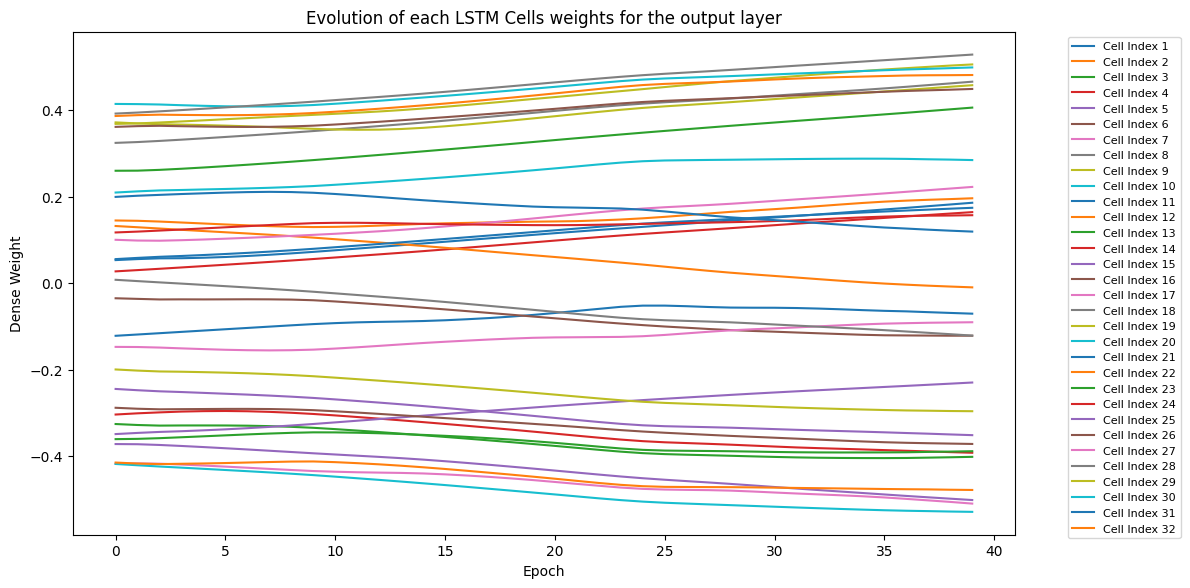

In [ ]:
# Plot the mean of all dense weights across epochs for each sample (f)

dense_weights_low = dense_weights_low.reshape(dense_weights_low.shape[0], dense_weights_low.shape[1])

final_weights = rank_by_absolute_value(dense_weights_low[-1])

plt.figure(figsize=(12, 6))
for i in range(dense_weights_low.shape[1]):  # Iterate over the 32 cell states
    plt.plot(range(dense_weights_low.shape[0]), dense_weights_low[:, i], label=f"Cell Index {i+1}")

plt.title("Evolution of each LSTM Cells weights for the output layer")
plt.xlabel("Epoch")
plt.ylabel("Dense Weight")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# This graph demonstrates what the average cell state value was for certain sample. \n Assuming we only have cell values between -1 and 1, a
plt.tight_layout()
plt.show()

Get the weighted contributions of each lstm cell by multiplying its value with its weight in the dense layer

In [ ]:
# Example data
arr1 = np.random.random((13, 32, 15000))  # Shape (13, 32, 15000)
arr2 = np.random.random(32)  # Shape (32,)

# Broadcasting arr2 across the second dimension of arr1
result = arr1 * arr2[:, np.newaxis]  # This reshapes arr2 to (32, 1) to allow broadcasting

# Verify the shape of the result
print(result.shape)  # Should be (13, 32, 15000)

(13, 32, 15000)


In [ ]:
# Assuming lstm_outputs is the output of the LSTM layer (batch_size, timesteps, lstm_units)
# d_weights and d_bias are the dense weights and bias (e.g., d_weights: (lstm_units, 1), d_bias: (1,))
lstm_outputs = high_noise_epoch_dict.get('hidden_states_activation')
print(lstm_outputs.shape)
print(dense_weights_low.shape)
print(dense_bias_low.shape)
print(dense_weights_low[0].shape)

weighted_contributions_by_epoch = []
for epoch in range(lstm_outputs.shape[0]):
    epoch_outputs = lstm_outputs[epoch]
    cell_weights = dense_weights_low[epoch]
    bias_value = dense_bias_low[epoch]

    contributions_with_bias = (epoch_outputs * cell_weights[:, np.newaxis]) + bias_value  # Adding bias to each prediction
    weighted_contributions_by_epoch.append(contributions_with_bias)

weighted_contributions_by_epoch = np.array(weighted_contributions_by_epoch)
print(weighted_contributions_by_epoch.shape)

(40, 13, 32, 15000)
(40, 32)
(40, 1)
(32,)
(40, 13, 32, 15000)


## Extract Meaning from Final Cell States

We know that the final cell state shows is a memory mechanism designed to retain information over long horizons. The value corresponds to what the LSTM deems important after preprocessing. In our case we learn with the 'final' cell state at every time step but that doesn't change its meaning:

The stronger the value the higher the meaning of a given cell. That cell may correlate to the cluster identification of a certain class.

1. Can a cell specialize on burst or noise detection?
2. Can a cell specialize on detecting certain patterns?
3. Can a cell specialize on detecting certain burst frequencies?

1. We start by analyzing the low Noise

In [ ]:
print(cell_states_low.shape) # 40 epochs, 13 sample sets, 32 LSTM cells
print(hidden_state_activation_on_pred_low.shape)
print(cell_state_activation_low.shape)

(40, 13, 32)

In [ ]:
np.median(cell_states_low)

0.0035183127

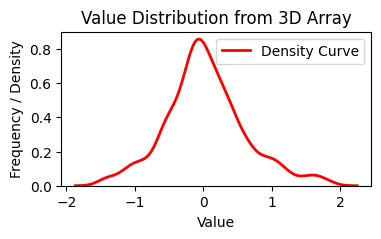

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Create a 3D NumPy array
data = cell_states_low[35:]

# Flatten the 3D array to 1D
flattened_data = data.ravel()

# Plot the value distribution
plt.figure(figsize=(4, 2))


# Density curve (optional)
sns.kdeplot(flattened_data, color='red', linewidth=2, label='Density Curve')

# Add labels and legend
plt.title("Distribution of cell state values")
plt.xlabel("Value")
plt.ylabel("Frequency / Density")
plt.legend()

plt.show()


(40, 32)
(40, 13)


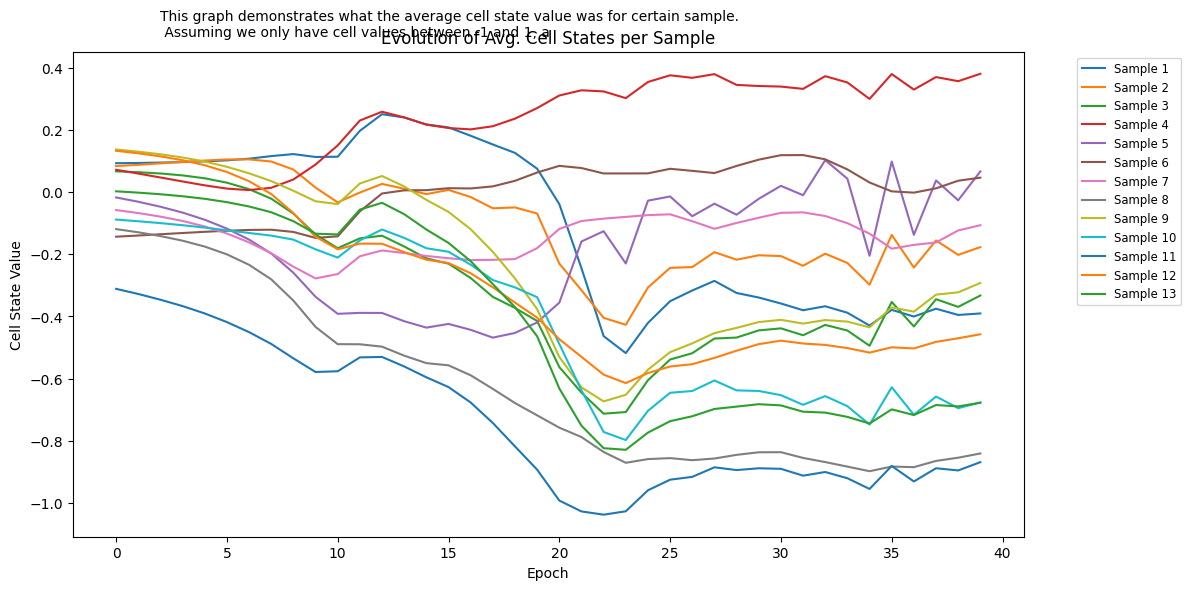

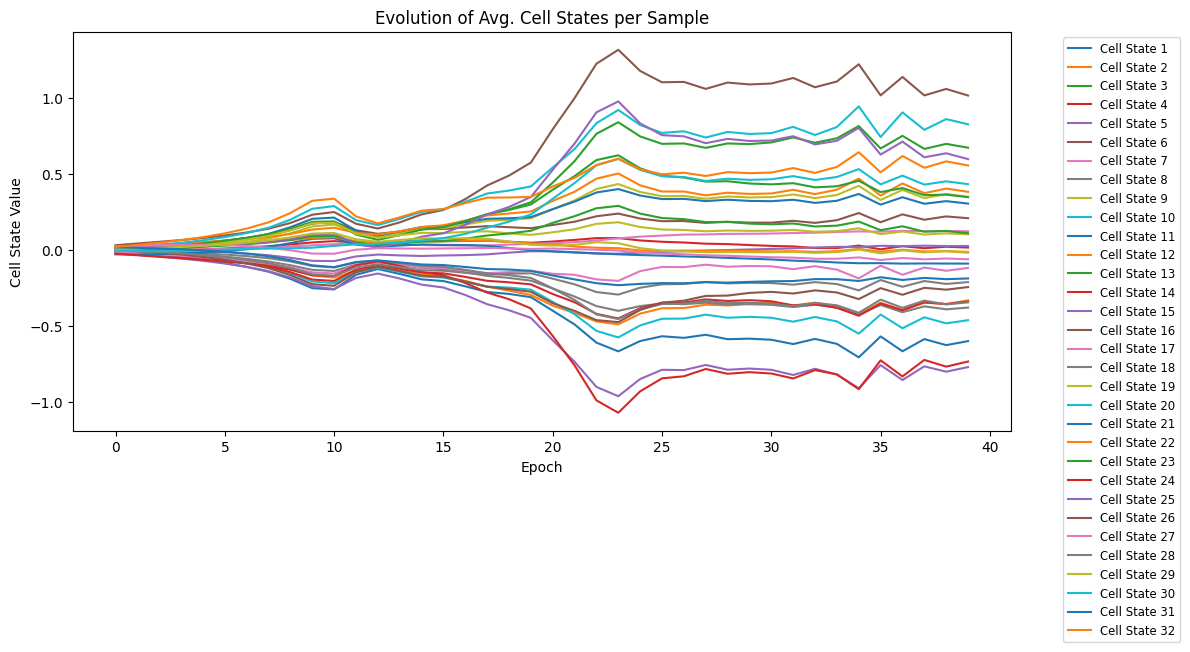

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cell_states` is your array of shape (40, 15, 32)

# Compute mean across samples (axis 1)
# Makes sense because all samples have same noise and frequency roughly
mean_states = np.mean(cell_states_low, axis=1)  # Shape: (40, 32)
mean_all_states = np.mean(cell_states_low, axis=2)
specific_cell = cell_states_low[:, :, 1]

print(mean_states.shape)
print(mean_all_states.shape)

# Plot the mean of all cell state's across epochs for each sample (f)
plt.figure(figsize=(12, 6))
for i in range(specific_cell.shape[1]):  # Iterate over the 32 cell states
    plt.plot(range(specific_cell.shape[0]), specific_cell[:, i], label=f"Sample {i+1}")

plt.title("Evolution of the Avg. of all Cell State Values per Sample")
plt.xlabel("Epoch")
plt.ylabel("Cell State Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
# This graph demonstrates what the average cell state value was for certain sample. \n Assuming we only have cell values between -1 and 1, a
plt.tight_layout()
plt.show()

# Plot each cell state's mean value across epochs
plt.figure(figsize=(12, 6))
for i in range(mean_states.shape[1]):  # Iterate over the 32 cell states
    plt.plot(range(mean_states.shape[0]), mean_states[:, i], label=f"Cell State {i+1}")

plt.title("Evolution of Avg. Cell States per Sample")
plt.xlabel("Epoch")
plt.ylabel("Cell State Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
''' THIS IS USED TO DETMINE DIFFERENCES BETWEEN SAMPLES,
    NOT EXPECTED TO CHANGE IF NOISE AND FREQUENCY ARE SAME'''

# Select a single sample (e.g., sample index 0)
single_sample_states_1 = cell_states_low[:, 0, :]  # Shape: (40, 32)
single_sample_states_2 = cell_states_low[:, 2, :]  # Shape: (40, 32)

# Plot each cell state for the selected sample
plt.figure(figsize=(12, 6))
for i in range(single_sample_states_1.shape[1]):  # Iterate over the 32 cell states
    plt.plot(range(single_sample_states_1.shape[0]), single_sample_states_1[:, i], label=f"Cell State {i+1}")

plt.title("Evolution of Cell States for Sample 0")
plt.xlabel("Epoch")
plt.ylabel("Cell State Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# Plot each cell state for the selected sample
plt.figure(figsize=(12, 6))
for i in range(single_sample_states_2.shape[1]):  # Iterate over the 32 cell states
    plt.plot(range(single_sample_states_2.shape[0]), single_sample_states_2[:, i], label=f"Cell State {i+1}")

plt.title("Evolution of Cell States for Sample 2")
plt.xlabel("Epoch")
plt.ylabel("Cell State Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


NameError: name 'cell_states_low' is not defined

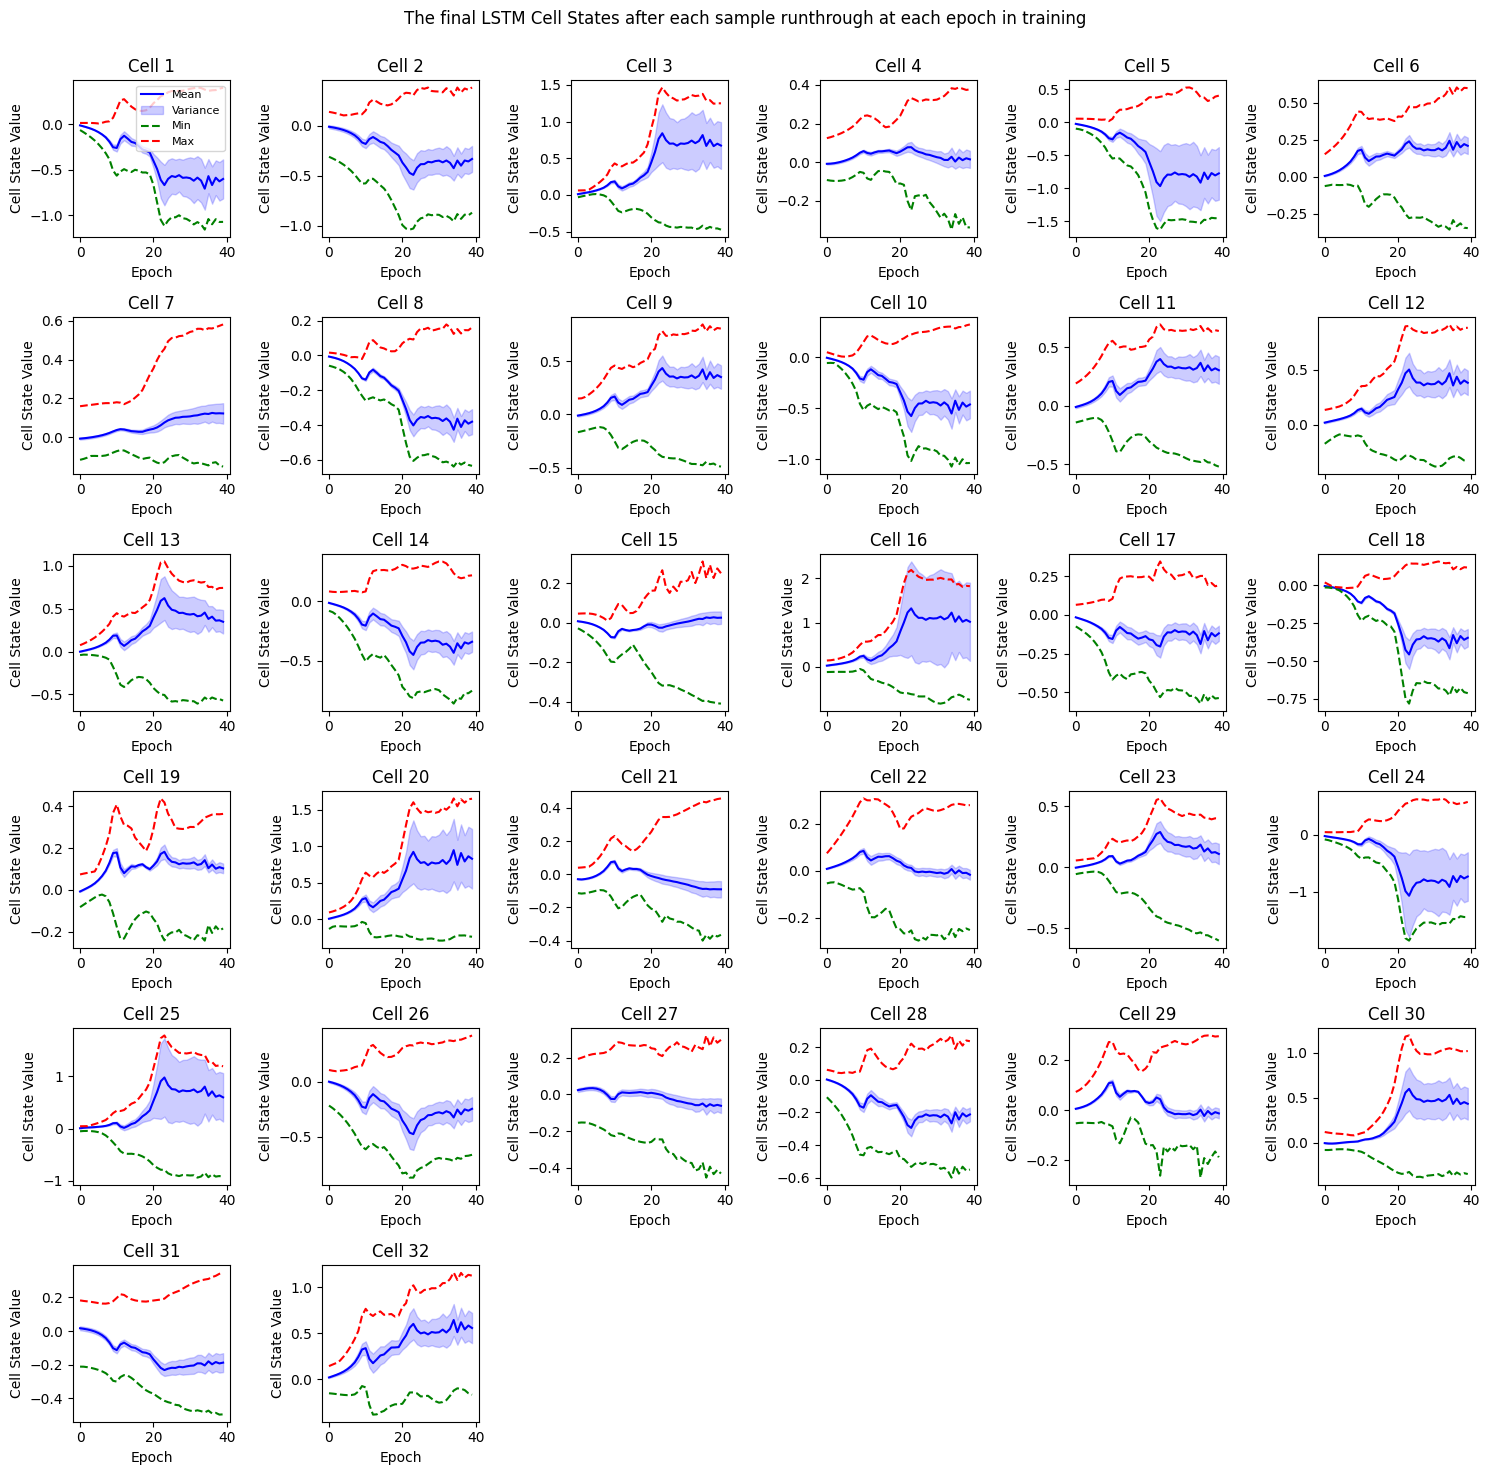

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cell_states` is your array of shape (40, 15, 32)
epochs, samples, num_cells = cell_states_low.shape

# Create a grid of subplots
n_rows = int(np.ceil(np.sqrt(num_cells)))  # Rows for the grid
n_cols = n_rows  # Square grid assumption

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Loop through each cell and plot its statistics
for cell_index in range(num_cells):
    chosen_cell = cell_states_low[:, :, cell_index]  # Shape: (40, 15)

    # Compute statistics
    mean_cell = np.mean(chosen_cell, axis=1)  # Shape: (40,)
    variance_cell = np.var(chosen_cell, axis=1)  # Shape: (40,)
    min_cell = np.min(chosen_cell, axis=1)  # Shape: (40,)
    max_cell = np.max(chosen_cell, axis=1)  # Shape: (40,)

    # Plot on the respective subplot
    ax = axes[cell_index]
    ax.plot(range(chosen_cell.shape[0]), mean_cell, label="Mean", color="blue")
    ax.fill_between(
        range(chosen_cell.shape[0]),
        mean_cell - variance_cell,
        mean_cell + variance_cell,
        color="blue",
        alpha=0.2,
        label="Variance"
    )
    ax.plot(range(chosen_cell.shape[0]), min_cell, label="Min", color="green", linestyle="--")
    ax.plot(range(chosen_cell.shape[0]), max_cell, label="Max", color="red", linestyle="--")

    # Add title and format
    ax.set_title(f"Cell {cell_index + 1}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cell State Value")

# Remove extra subplots if any
for i in range(num_cells, len(axes)):
    fig.delaxes(axes[i])

# Add legend for the first plot only
axes[0].legend(loc="upper right", fontsize=8)

fig.suptitle("The final LSTM Cell States after each sample runthrough at each epoch in training")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


## Extract Meaning from the hidden cell activations

In [ ]:

print("Shape of lstm_activation_on_pred:", weighted_contributions_by_epoch.shape)
print("Meaning of each dimension:")
print("Dimension 0: Number of Epochs: ", weighted_contributions_by_epoch.shape[0])
print("Dimension 1: Number of Samples in the Test Set:", weighted_contributions_by_epoch.shape[1])
print("Dimension 2: Number of LSTM Units/Cells:", weighted_contributions_by_epoch.shape[2])
print("Dimension 3: Number of Timesteps in each Sample:", weighted_contributions_by_epoch.shape[3])


Shape of lstm_activation_on_pred: (40, 13, 32, 15000)
Meaning of each dimension:
Dimension 0: Number of Epochs:  40
Dimension 1: Number of Samples in the Test Set: 13
Dimension 2: Number of LSTM Units/Cells: 32
Dimension 3: Number of Timesteps in each Sample: 15000


In [ ]:
final_weights

[(1, 17, 0.5288509),
 (2, 29, -0.52828735),
 (3, 26, -0.5091799),
 (4, 8, 0.5060597),
 (5, 4, -0.5009609),
 (6, 9, 0.4991528),
 (7, 21, 0.48160675),
 (8, 31, -0.47766986),
 (9, 7, 0.46618736),
 (10, 18, 0.4580478),
 (11, 25, 0.44939756),
 (12, 2, 0.40627724),
 (13, 12, -0.40108448),
 (14, 13, -0.39167908),
 (15, 22, -0.38805673),
 (16, 15, -0.3713025),
 (17, 24, -0.35095757),
 (18, 28, -0.29559827),
 (19, 19, 0.2850053),
 (20, 14, -0.22927813),
 (21, 16, 0.22291102),
 (22, 1, 0.19666268),
 (23, 10, 0.18630227),
 (24, 20, 0.17465882),
 (25, 3, 0.16463652),
 (26, 23, 0.1575331),
 (27, 5, -0.121059656),
 (28, 27, -0.12080524),
 (29, 30, 0.119639196),
 (30, 6, -0.089918785),
 (31, 0, -0.070107765),
 (32, 11, -0.009268146)]

In [ ]:
def visualize_lstm_activity(time_vec, signal_sample, ground_truth, epoch_lstm_act, epoch_lstm_act_weighted, model_pred, cell_ids_good, cell_ids_bad, epoch_idx, title_suffix=""):
    """
    Visualizes LSTM cell activations, predictions, and ground truth.

    Args:
        time_vec: Time vector for the data.
        signal_sample: The raw signal data sample.
        ground_truth: Ground truth labels for the sample.
        epoch_lstm_act: LSTM cell activations for the epoch.
        epoch_lstm_act_weighted: Weighted LSTM cell activations.
        model_pred: Model predictions for the epoch.
        cell_ids_good: IDs of the top-performing LSTM cells.
        cell_ids_bad: IDs of the worst-performing LSTM cells.
        epoch_idx: Index of the current epoch.
        title_suffix: Optional suffix to add to the plot titles.
    """

    fig, ax = plt.subplots(4, 1, figsize=(20, 14), sharex=True)

    # Signal visualization
    ax[0].plot(time_vec, signal_sample.flatten(), label='Signal', alpha=0.5)
    ax[0].stackplot(time_vec, ground_truth * 4, labels=["Burst", "Noise"])
    ax[0].stackplot(time_vec, ground_truth * -4, labels=["Burst", "Noise"])
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title(f"True LFP Signal {title_suffix}")
    ax[0].legend()
    ax[0].set_xlim(55, 60)

    # ... (Rest of the plotting logic remains the same, using cell_ids_good, cell_ids_bad, etc.)

    plt.show()

5 worst LSTM Cells: [0, 11]
5 best LSTM Cells: [17, 29]


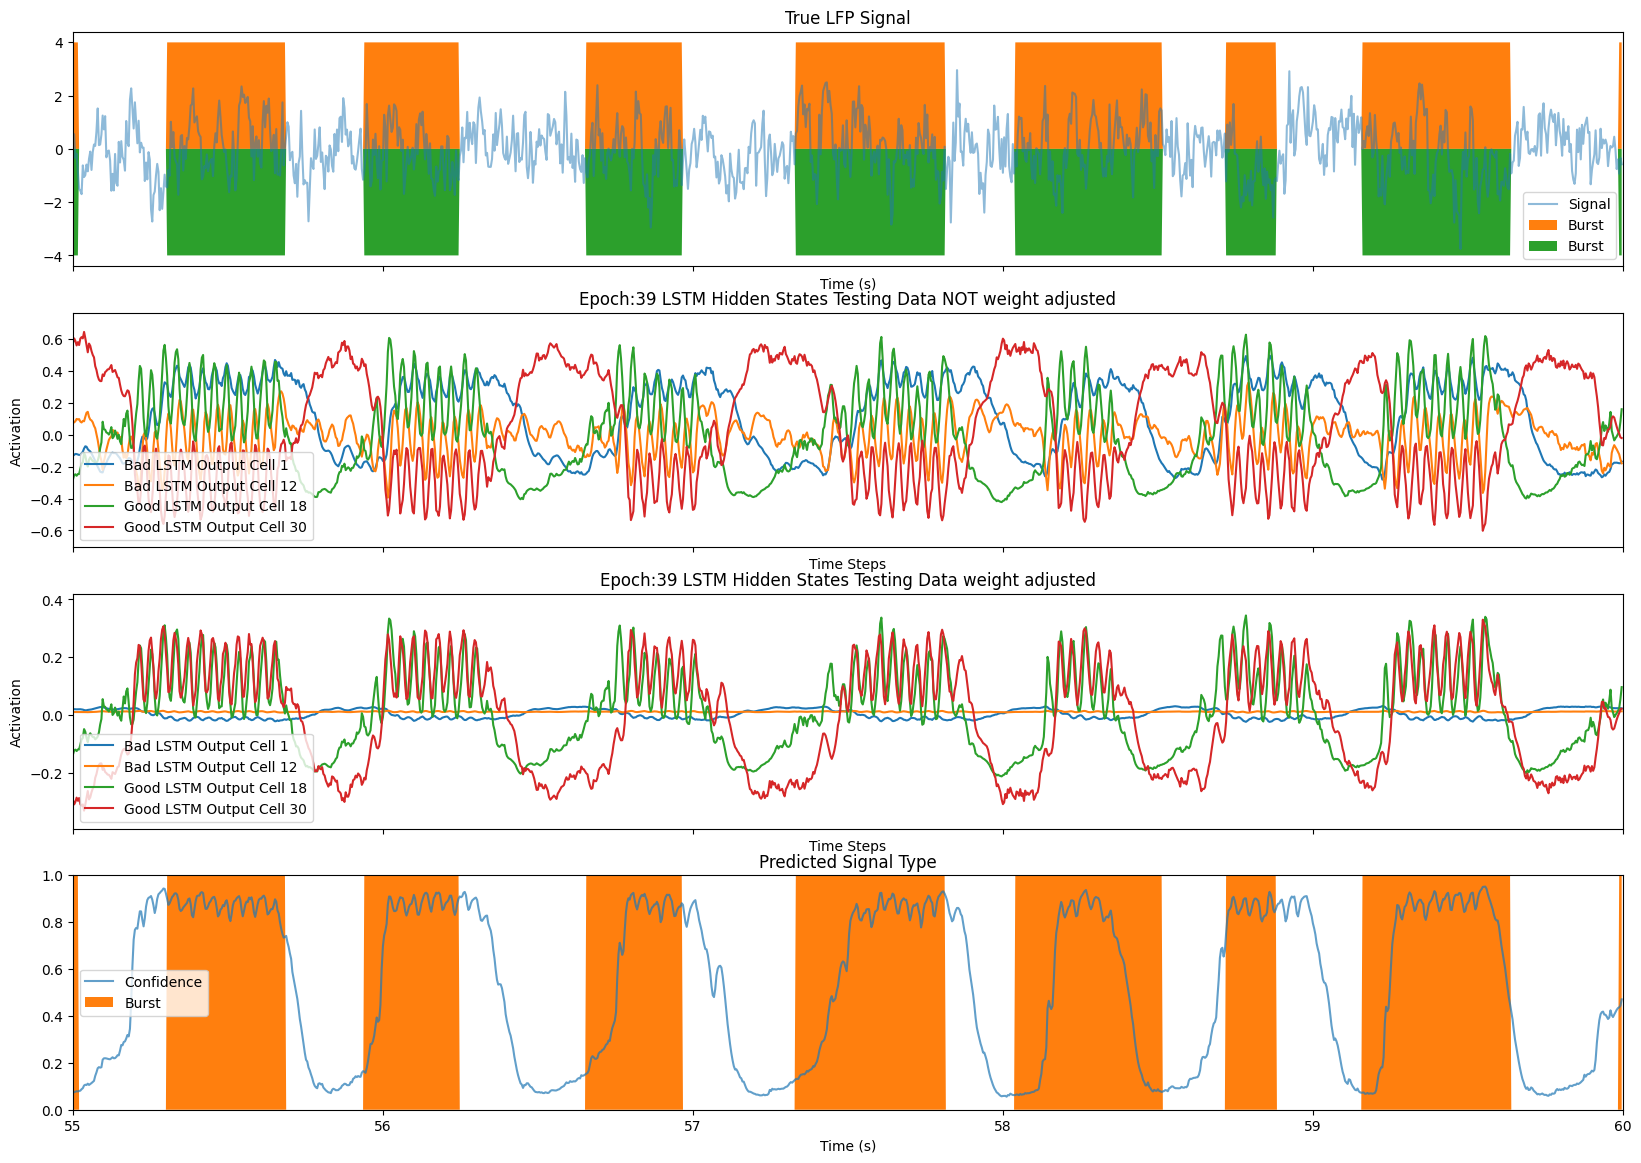

In [ ]:
 time_vec = np.linspace(0, 60, 60 * 250, endpoint=False)

n_seconds = 0
sample_number = 4
offset = sample_number * len(time_vec)

# Define Raw Data
signal_sample = X_test_high[sample_number].flatten()
ground_truth = y_test_high[sample_number].flatten()

# Getting the top n best and worst LSTM cells based on their assigned weight
top_n = 2

cell_ids_good = get_top_n_cell_IDs(final_weights, top_n)
cell_ids_bad = [item[1] for item in final_weights[-top_n:]]
print(f"5 worst LSTM Cells: {cell_ids_bad}")
print(f"5 best LSTM Cells: {cell_ids_good}")

epoch_model_pred_low = high_noise_epoch_dict.get('epoch_model_predictions')


for idx in range(weighted_contributions_by_epoch.shape[0]):
    epoch_lstm_act_weighted = weighted_contributions_by_epoch[idx]
    epoch_lstm_act = high_noise_epoch_dict.get('hidden_states_activation')[idx]

    model_pred = epoch_model_pred_low[idx]
    model_pred_binary = np.rint(model_pred).astype(int)

    if idx == 39:

      # Visualize the actual vs predicted labels
      fig, ax = plt.subplots(4, 1, figsize=(20, 14), sharex=True)

      # visulizing signal
      ax[0].plot(time_vec, signal_sample.flatten(), label='Signal', alpha=0.5)
      ax[0].stackplot(time_vec, ground_truth*4, labels=["Burst", "Noise"])
      ax[0].stackplot(time_vec, ground_truth*-4, labels=["Burst", "Noise"])
      ax[0].set_xlabel("Time (s)")
      ax[0].set_title("True LFP Signal")
      ax[0].legend()
      ax[0].set_xlim(55,60)

      # visualize the LSTM cell activation upon the singular input feature
      # i stands for the index of the output unit/cell
      for cell_id in cell_ids_bad:
          ax[1].plot(time_vec, epoch_lstm_act[sample_number][cell_id],  label=f'Bad LSTM Output Cell {cell_id+1}')
      for cell_id in cell_ids_good:
          ax[1].plot(time_vec, epoch_lstm_act[sample_number][cell_id],  label=f'Good LSTM Output Cell {cell_id+1}')
      ax[1].set_title(f'Epoch:{idx} LSTM Hidden States Testing Data NOT weight adjusted')
      ax[1].set_xlabel('Time Steps')
      ax[1].set_ylabel('Activation')
      ax[1].set_xlim(55,60)
      ax[1].legend()

      # visualize the LSTM cell activation upon the singular input feature
      # i stands for the index of the output unit/cell
      for cell_id in cell_ids_bad:
          ax[2].plot(time_vec, epoch_lstm_act_weighted[sample_number][cell_id],  label=f'Bad LSTM Output Cell {cell_id+1}')
      for cell_id in cell_ids_good:
          ax[2].plot(time_vec, epoch_lstm_act_weighted[sample_number][cell_id],  label=f'Good LSTM Output Cell {cell_id+1}')
      ax[2].set_title(f'Epoch:{idx} LSTM Hidden States Testing Data weight adjusted')
      ax[2].set_xlabel('Time Steps')
      ax[2].set_ylabel('Activation')
      ax[2].set_xlim(55,60)
      ax[2].legend()

      # visulizing burst confidence
      ax[3].plot(time_vec, model_pred[sample_number].flatten(), label='Confidence', alpha=0.7)
      ax[3].stackplot(time_vec, ground_truth, labels=["Burst", "Noise"])
      ax[3].set_xlabel("Time (s)")
      ax[3].set_title("Predicted Signal Type")
      ax[3].legend()
      ax[3].set_xlim(55,60)
      ax[3].set_ylim(0,1)

      plt.show()


**Interpretation:**

This showcases the hidden cell states value and the predicted outcome.

My issue is, that the cell state does not predict long-term enough. Clearly visible be the value fluctuatoin during oscillation.

Also the Dense layer clearly neglect a couple of LSTM Cells completely, suggesting that potentially less Cells would be sufficient.



In [ ]:
model.get_layer("lstm_layer").get_weights()[2].shape

(128,)

## Experiment with individual LSTM gates (no continuation for now)

In [ ]:
# Example: Splitting weights by gates
units = 128  # LSTM units
kernel_weights = lstm_layer.get_weights()[0]  # Shape (features, units * 4)
recurrent_weights = lstm_layer.get_weights()[1]  # Shape (units, units * 4)
biases = lstm_layer.get_weights()[2]  # Shape (units * 4)

# Split into 4 gates
kernel_forget, kernel_input, kernel_candidate, kernel_output = np.split(kernel_weights, 4, axis=1)
recurrent_forget, recurrent_input, recurrent_candidate, recurrent_output = np.split(recurrent_weights, 4, axis=1)
bias_forget, bias_input, bias_candidate, bias_output = np.split(biases, 4)

In [ ]:
print(bias_output.shape)

(32,)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract input-to-hidden weights (example shape: (64, 256))
lstm_layer = model.get_layer("lstm_layer")
weights = lstm_layer.get_weights()[1]  # Input-to-hidden weights

top_20_idx = np.argsort(weights[0])[-20:]
top_20_values = [weights[0][i] for i in top_20_idx]

plt.figure(figsize=(12, 8))
sns.heatmap(kernel_output, cmap="viridis")
plt.title("Hidden-to-Hidden Output Weights Heatmap")
plt.xlabel("LSTM Units")
plt.ylabel("Input Features")
plt.show()


IndexError: Inconsistent shape between the condition and the input (got (32, 1) and (32,))

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Get predictions and states for a sample
predictions= model.predict(X_test[0:1])

print("Predictions shape:", predictions.shape)
print("Final Hidden State shape:", final_hidden_state.shape)
print("Final Cell State shape:", final_cell_state.shape)

# To analyze hidden states over all timesteps
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('lstm_layer').output)
lstm_output_sequence, state_h, state_c = intermediate_model.predict(X_test[0:1])

print("LSTM Output Sequence shape:", lstm_output_sequence.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Predictions shape: (1, 15000, 1)


NameError: name 'final_hidden_state' is not defined

## Rest Code (not used)

In [ ]:
# Predict on test data
y_pred = (predictions > 0.5).astype("int32")
print(y_pred.shape)

# Evaluate the model
y_test_flat = y_test[0].flatten()
y_pred_flat = y_pred[0].flatten()
accuracy = accuracy_score(y_test_flat, y_pred_flat)
classification_rep = classification_report(y_test_flat, y_pred_flat, target_names=['Noise', 'Burst'])

print(f"Accuracy: {accuracy:.2f}")
print(classification_rep)

(15, 15000, 1)
Accuracy: 0.93
              precision    recall  f1-score   support

       Noise       0.95      0.95      0.95     10741
       Burst       0.88      0.88      0.88      4259

    accuracy                           0.93     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.93      0.93      0.93     15000



In [ ]:
history.model.layers[1].get_weights()[0].shape

(1, 256)

In [ ]:
import matplotlib.pyplot as plt

# Example: Visualize the first 10 dimensions of the hidden state over time
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.plot(lstm_output_sequence[0, :1000, i], label=f'Dimension {i}')
plt.title('LSTM Hidden States Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Activation')
plt.legend()
plt.show()

NameError: name 'lstm_output_sequence' is not defined

<Figure size 1500x600 with 0 Axes>

In [ ]:
y_pred_flat

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
n_samples, n_timesteps, n_cats  = predictions.shape  # (8, 15000, 5)
y_pred_reshaped = y_pred_flat.flatten()
y_test_classes = y_test[:1].flatten()
# y_pred_classes = np.argmax(y_pred_reshaped, axis=1).flatten()

print(y_pred_flat.shape)
print(y_test_classes.shape)
print(y_pred_flat[:10])
print(y_test_classes[:10])

(15000,)
(15000,)
[0 0 0 0 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


0


(16, 15000)


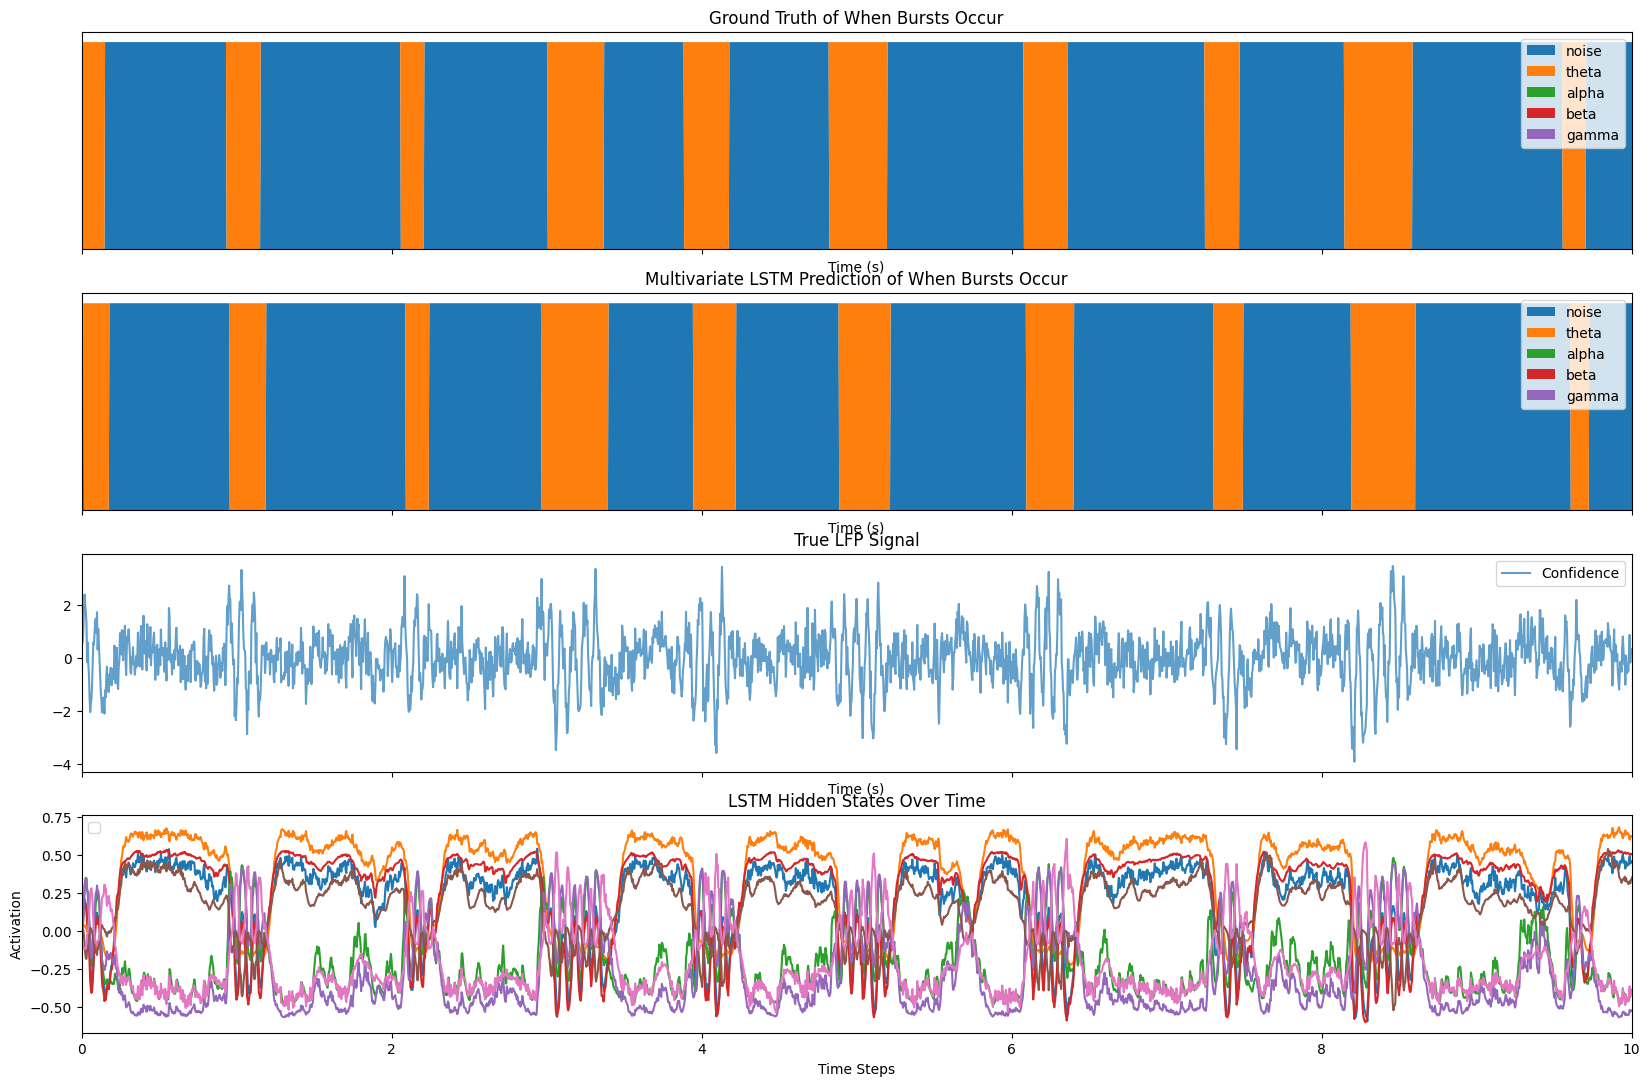

In [ ]:
time_vec = np.linspace(0, 60, 60 * 250, endpoint=False)

sample_number = 0
offset = sample_number * len(time_vec)
print(offset)
y_vis_real = y_test_classes[offset:offset + len(time_vec)].flatten()
y_vis_pred = y_pred_flat[offset:offset + len(time_vec)].flatten()


# Define class names
class_names = ['noise', 'theta', 'alpha', 'beta', 'gamma']

y_vis_real = one_hot_encode_single_sample(y_vis_real).T
y_vis_pred = one_hot_encode_single_sample(y_vis_pred).T

# Define Raw Data
signal_sample = X_test[sample_number].flatten()

# Visualize the actual vs predicted labels
fig, ax = plt.subplots(4, 1, figsize=(20, 13), sharex=True)

# visulizing burst labels as colors
ax[0].stackplot(time_vec, y_vis_real, labels=class_names)
ax[0].set_xlabel("Time (s)")
ax[0].set_yticks([]) #y-axis does not mean anything
ax[0].set_title("Ground Truth of When Bursts Occur")
ax[0].legend()
ax[0].set_xlim(0, 10)

# visulizing burst labels as colors
ax[1].stackplot(time_vec, y_vis_pred, labels=class_names)
ax[1].set_xlabel("Time (s)")
ax[1].set_yticks([]) #y-axis does not mean anything
ax[1].set_title("Multivariate LSTM Prediction of When Bursts Occur")
ax[1].legend()
ax[0].set_xlim(0, 10)

# visulizing burst confidence
ax[2].plot(time_vec, signal_sample, label='Confidence', alpha=0.7)
ax[2].set_xlabel("Time (s)")
ax[2].set_title("True LFP Signal")
ax[2].legend()

print(hidden_states[0].T.shape)

for i in range(7):
    ax[3].plot(time_vec, hidden_states[0].T[i])
ax[3].set_title('LSTM Hidden States Over Time')
ax[3].set_xlabel('Time Steps')
ax[3].set_ylabel('Activation')
ax[3].legend()



In [ ]:
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step


In [ ]:
y_pred.shape

(50, 15000, 5)

In [ ]:
y_test.shape

(50, 15000, 1)

In [ ]:
n_samples, n_timesteps, n_cats  = y_pred.shape  # (8, 15000, 5)
y_pred_reshaped = y_pred.reshape(-1, n_cats, 1)
y_test_classes = y_test.flatten()
y_pred_classes = np.argmax(y_pred_reshaped, axis=1).flatten()

print(y_pred_classes.shape)
print(y_test_classes.shape)
print(y_pred_classes[:10])
print(y_test_classes[:10])

(750000,)
(750000,)
[2 2 1 4 4 4 4 4 4 2]
[4 4 4 4 4 4 4 4 4 4]


In [ ]:
from sklearn.metrics import classification_report

# Define class names
class_names = ['noise', 'theta', 'alpha', 'beta', 'gamma']

# Generate and print classification report
report = classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=class_names,
    zero_division=0
)
print(report)

              precision    recall  f1-score   support

       noise       0.92      0.96      0.94    401699
       theta       0.77      0.62      0.69     20039
       alpha       0.88      0.84      0.86     93155
        beta       0.86      0.90      0.88     75099
       gamma       0.97      0.90      0.93    160008

    accuracy                           0.92    750000
   macro avg       0.88      0.84      0.86    750000
weighted avg       0.92      0.92      0.92    750000



In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/5_class_lstm_model.keras")

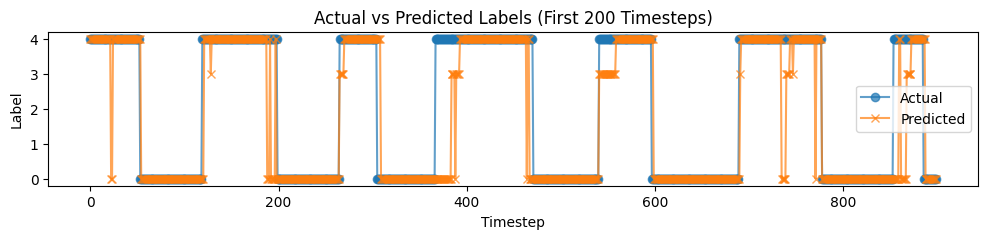

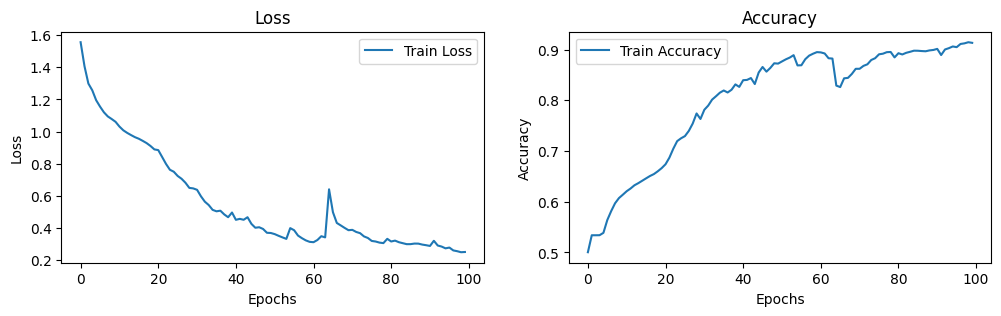

In [ ]:
# Visualize the actual vs predicted labels
plt.figure(figsize=(12, 2))
plt.plot(y_test_classes[200:1100], label='Actual', marker='o', alpha=0.7)
plt.plot(y_pred_classes[200:1100], label='Predicted', marker='x', alpha=0.7)
plt.title("Actual vs Predicted Labels (First 200 Timesteps)")
plt.xlabel("Timestep")
plt.ylabel("Label")
plt.legend()
plt.show()


# Plot training history
plt.figure(figsize=(12, 3))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



## Result visualization


In [ ]:
time_vec = np.linspace(0, 60, 60 * 250, endpoint=False)

sample = 14
offset = sample * len(time_vec)

y_vis_real = y_test_classes[offset:offset + len(time_vec)].flatten()
y_vis_pred = y_pred_classes[offset:offset + len(time_vec)].flatten()

print(y_test.shape)
print(y_pred.shape)

(50, 15000, 1)
(50, 15000, 5)


In [ ]:
print(y_vis_real[:20])
print(y_vis_pred[:20])
print(X_test[1][:10][0])
print(X_test[4][:10][0])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[2 2 2 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 0.2826065   0.07986643  0.03253428  0.05068686  0.06474388 -0.0164771
 -0.05230596 -0.0225678   0.03428201  0.09493223  0.06578462  0.14442649]
[ 0.08140251  0.00662637  0.01612178  0.03311732  0.09814764  0.249153
 -0.09704623 -0.20146736 -0.15636777 -0.11099491 -0.0812766  -0.09075833]


15000


(0.0, 10.0)

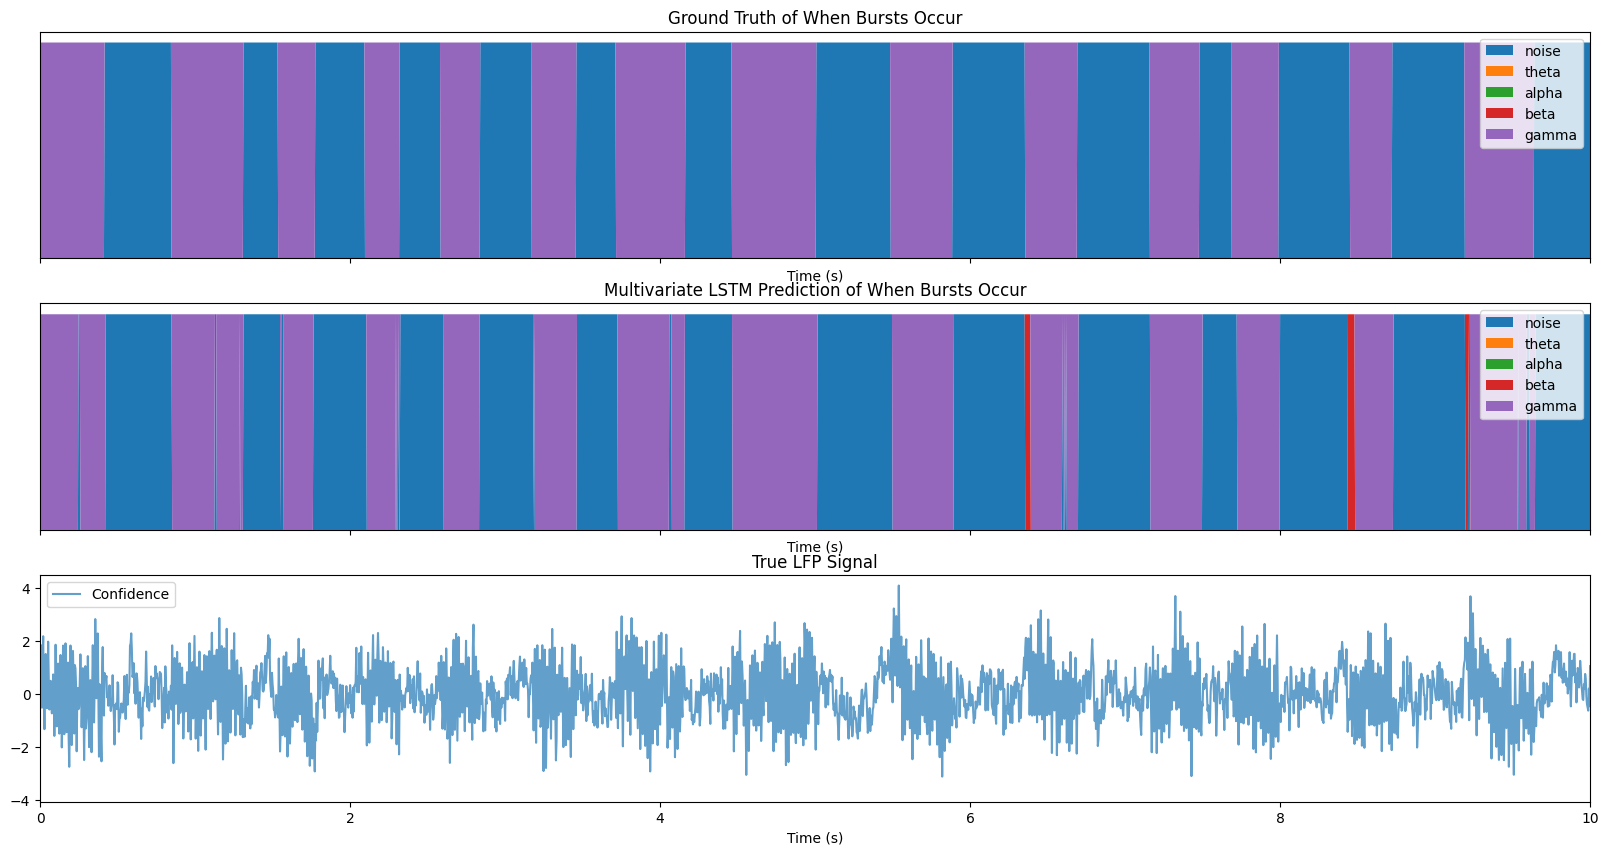

In [ ]:
time_vec = np.linspace(0, 60, 60 * 250, endpoint=False)

# Bad ones are 1, 7, 8
sample_number = 1
offset = sample_number * len(time_vec)
print(offset)
y_vis_real = y_test_classes[offset:offset + len(time_vec)].flatten()
y_vis_pred = y_pred_classes[offset:offset + len(time_vec)].flatten()


# Define class names
class_names = ['noise', 'theta', 'alpha', 'beta', 'gamma']

y_vis_real = one_hot_encode_single_sample(y_vis_real).T
y_vis_pred = one_hot_encode_single_sample(y_vis_pred).T

# Define Raw Data
label_sample = y_test[sample_number].flatten()
signal_sample = [i[0] for i in X_test[sample_number]]
power_sample = [i[1] for i in X_test[sample_number]]
# Wavelet_sample = [i[2] for i in X_train[sample_number]]
# Wavelet_sample2 = [i[3] for i in X_train[sample_number]]
# H_amp_sample = [i[4] for i in X_train[sample_number]]


# Visualize the actual vs predicted labels
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# visulizing burst labels as colors
ax[0].stackplot(time_vec, y_vis_real, labels=class_names)
ax[0].set_xlabel("Time (s)")
ax[0].set_yticks([]) #y-axis does not mean anything
ax[0].set_title("Ground Truth of When Bursts Occur")
ax[0].legend()
ax[0].set_xlim(0, 10)

# visulizing burst labels as colors
ax[1].stackplot(time_vec, y_vis_pred, labels=class_names)
ax[1].set_xlabel("Time (s)")
ax[1].set_yticks([]) #y-axis does not mean anything
ax[1].set_title("Multivariate LSTM Prediction of When Bursts Occur")
ax[1].legend()
ax[0].set_xlim(0, 10)

# visulizing burst confidence
ax[2].plot(time_vec, signal_sample, label='Confidence', alpha=0.7)
ax[2].set_xlabel("Time (s)")
ax[2].set_title("True LFP Signal")
ax[2].legend()
ax[0].set_xlim(0, 10)
